# Bioacoustic Dataset Analysis and Visualization
## Understanding the DCASE Few-Shot Bioacoustic Event Detection Dataset

This notebook provides comprehensive visualizations to understand the structure, distribution, and characteristics of the bioacoustic dataset used for few-shot event detection.

## Section 1: Load Configuration and Dataset Metadata
Loading the config.yaml file and initializing dataset statistics structures.

In [3]:
import sys
from pathlib import Path
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from collections import defaultdict
import warnings
import re

warnings.filterwarnings("ignore")

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["font.size"] = 10

# Load configuration
config_path = Path("../conf/config.yaml")
if not config_path.exists():
    config_path = Path("conf/config.yaml")

with open(config_path, "r") as f:
    config = yaml.safe_load(f)

# Resolve placeholders in config paths
def resolve_config_paths(config):
    """Resolve ${...} placeholders in config paths."""
    # Get root_dir first
    root_dir = config["path"]["root_dir"]
    
    # Resolve all path values
    for key in config["path"]:
        value = config["path"][key]
        if isinstance(value, str) and "${path.root_dir}" in value:
            config["path"][key] = value.replace("${path.root_dir}", root_dir)
    
    return config

config = resolve_config_paths(config)

print("Configuration loaded successfully!")
print(f"Train directory: {config['path']['train_dir']}")
print(f"Validation directory: {config['path']['eval_dir']}")
print(f"Evaluation directory: {config['path']['test_dir']}")

# Extract paths
train_dir = Path(config["path"]["train_dir"])
val_dir = Path(config["path"]["eval_dir"])
test_dir = Path(config["path"]["test_dir"])

# Verify paths exist
for path_name, path_obj in [("Train", train_dir), ("Validation", val_dir), ("Evaluation", test_dir)]:
    if not path_obj.exists():
        print(f"WARNING: {path_name} directory does not exist: {path_obj}")
    else:
        print(f"✓ {path_name} directory found: {path_obj}")


Configuration loaded successfully!
Train directory: /data/msc-proj/Training_Set
Validation directory: /data/msc-proj/Validation_Set_DSAI_2025_2026
Evaluation directory: /data/msc-proj/Evaluation_Set_DSAI_2025_2026
✓ Train directory found: /data/msc-proj/Training_Set
✓ Validation directory found: /data/msc-proj/Validation_Set_DSAI_2025_2026
✓ Evaluation directory found: /data/msc-proj/Evaluation_Set_DSAI_2025_2026


## Section 2: Analyze Dataset Statistics from Directories
Collecting statistics from all audio and annotation files.

In [4]:
def parse_annotation_file(csv_path):
    """Parse annotation CSV file and extract statistics."""
    try:
        # Try to detect the delimiter - the file might use comma or tab
        with open(csv_path, 'r') as f:
            first_line = f.readline()
            if ',' in first_line:
                sep = ','
            else:
                sep = '\t'
        
        df = pd.read_csv(csv_path, sep=sep)
        if df.empty:
            return {}, {}
        
        classes = {}
        pos_counts = defaultdict(int)
        neg_counts = defaultdict(int)
        unk_counts = defaultdict(int)
        
        # Class columns start from index 3 (after Audiofilename, Starttime, Endtime)
        for col in df.columns[3:]:
            col_name = col.strip()
            pos = (df[col] == "POS").sum()
            neg = (df[col] == "NEG").sum()
            unk = (df[col] == "UNK").sum()
            
            if pos > 0 or neg > 0 or unk > 0:
                classes[col_name] = {
                    "pos": pos,
                    "neg": neg,
                    "unk": unk,
                }
                pos_counts[col_name] += pos
                neg_counts[col_name] += neg
                unk_counts[col_name] += unk
        
        return classes, {"pos": pos_counts, "neg": neg_counts, "unk": unk_counts}
    except Exception as e:
        print(f"Error parsing {csv_path}: {e}")
        return {}, {}


def analyze_directory(directory, subset_name):
    """Analyze all audio files in a directory."""
    stats = {
        "subset": subset_name,
        "folders": {},
        "total_recordings": 0,
        "total_classes": set(),
        "total_events_pos": 0,
        "total_events_neg": 0,
        "all_classes": defaultdict(lambda: {"pos": 0, "neg": 0, "unk": 0}),
    }
    
    subdirs = sorted([d for d in directory.iterdir() if d.is_dir()])
    
    for subdir in subdirs:
        folder_name = subdir.name
        audio_files = sorted(subdir.glob("*.wav"))
        
        if not audio_files:
            continue
        
        folder_stats = {
            "name": folder_name,
            "num_recordings": len(audio_files),
            "classes": defaultdict(lambda: {"pos": 0, "neg": 0, "unk": 0}),
            "total_events_pos": 0,
            "total_events_neg": 0,
        }
        
        for audio_file in audio_files:
            csv_file = audio_file.with_suffix(".csv")
            
            if csv_file.exists():
                classes, _ = parse_annotation_file(csv_file)
                for class_name, counts in classes.items():
                    folder_stats["classes"][class_name]["pos"] += counts["pos"]
                    folder_stats["classes"][class_name]["neg"] += counts["neg"]
                    folder_stats["classes"][class_name]["unk"] += counts["unk"]
                    folder_stats["total_events_pos"] += counts["pos"]
                    folder_stats["total_events_neg"] += counts["neg"]
                    
                    stats["total_classes"].add(class_name)
                    stats["all_classes"][class_name]["pos"] += counts["pos"]
                    stats["all_classes"][class_name]["neg"] += counts["neg"]
                    stats["all_classes"][class_name]["unk"] += counts["unk"]
        
        stats["folders"][folder_name] = folder_stats
        stats["total_recordings"] += folder_stats["num_recordings"]
        stats["total_events_pos"] += folder_stats["total_events_pos"]
        stats["total_events_neg"] += folder_stats["total_events_neg"]
    
    return stats


# Analyze all subsets
print("Analyzing Training Set...")
train_stats = analyze_directory(train_dir, "Training")

print("Analyzing Validation Set...")
val_stats = analyze_directory(val_dir, "Validation")

print("Analyzing Evaluation Set...")
eval_stats = analyze_directory(test_dir, "Evaluation")

print(f"\nTraining Set: {train_stats['total_recordings']} recordings, {len(train_stats['total_classes'])} classes, {train_stats['total_events_pos']} POS events")
print(f"Validation Set: {val_stats['total_recordings']} recordings, {len(val_stats['total_classes'])} classes, {val_stats['total_events_pos']} POS events")
print(f"Evaluation Set: {eval_stats['total_recordings']} recordings, {len(eval_stats['total_classes'])} classes, {eval_stats['total_events_pos']} POS events")

Analyzing Training Set...
Analyzing Validation Set...
Analyzing Evaluation Set...

Training Set: 174 recordings, 47 classes, 7677 POS events
Validation Set: 12 recordings, 1 classes, 645 POS events
Evaluation Set: 31 recordings, 1 classes, 155 POS events


## Section 3: Visualize Dataset Distribution Across Subsets
Bar charts showing recordings across Training Set subfolders and dataset divisions.

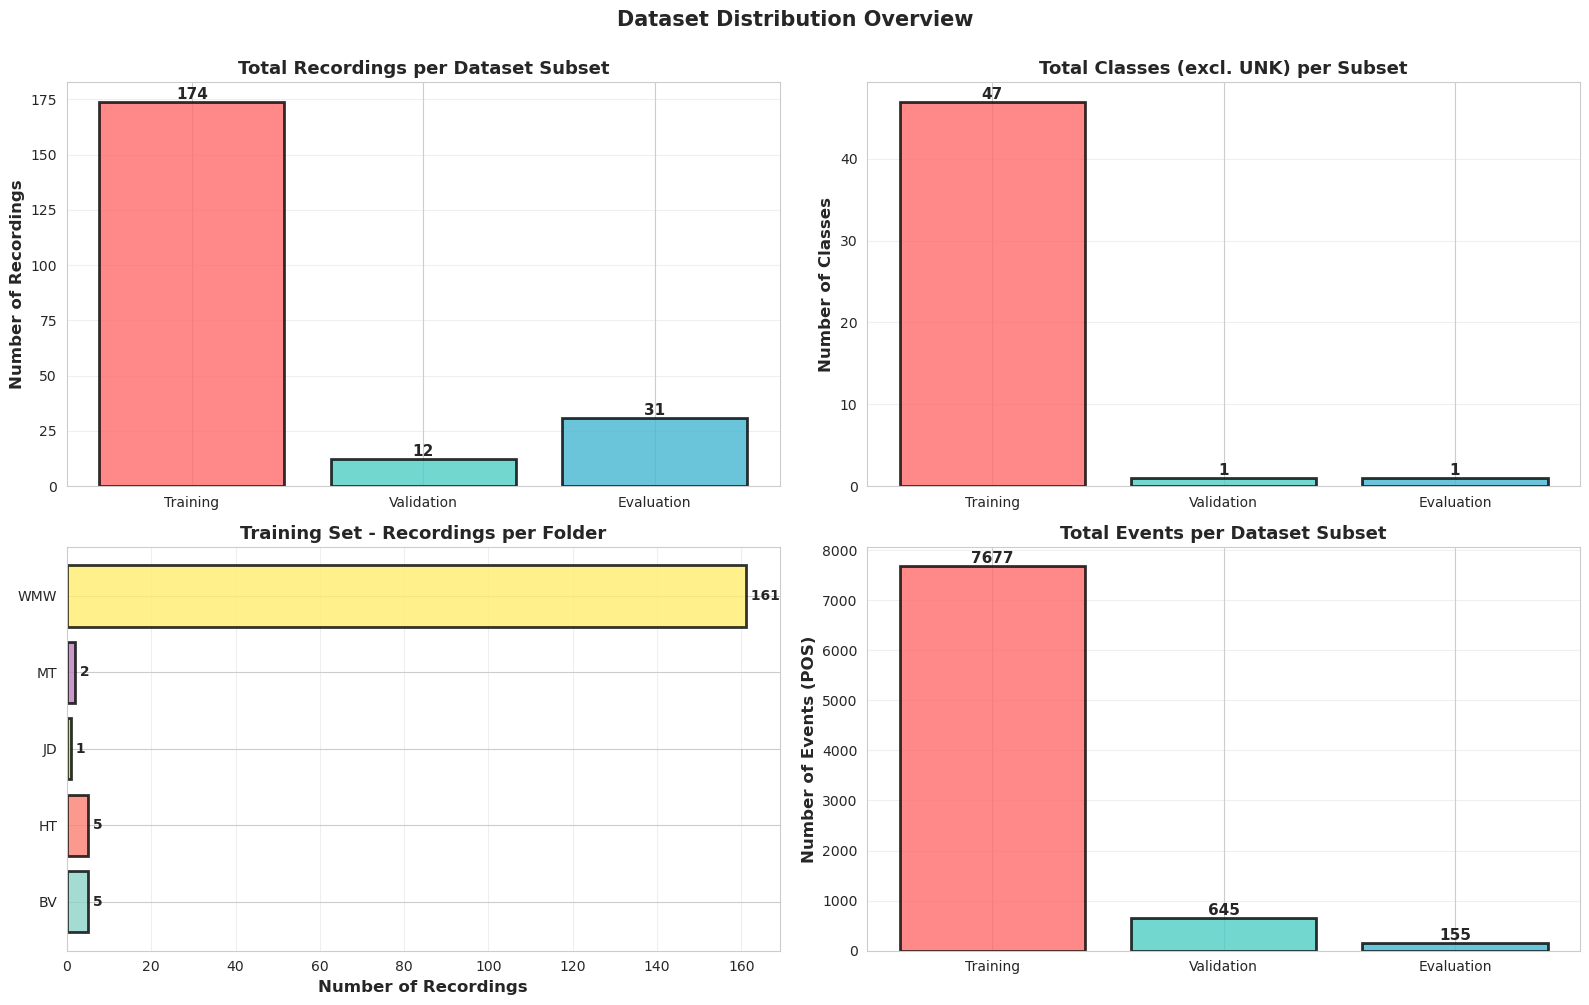

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Overview - Recordings per subset
ax = axes[0, 0]
subsets_names = ["Training", "Validation", "Evaluation"]
subset_recordings = [
    train_stats["total_recordings"],
    val_stats["total_recordings"],
    eval_stats["total_recordings"]
]
colors = ["#FF6B6B", "#4ECDC4", "#45B7D1"]
bars = ax.bar(subsets_names, subset_recordings, color=colors, alpha=0.8, edgecolor="black", linewidth=2)
ax.set_ylabel("Number of Recordings", fontsize=12, fontweight="bold")
ax.set_title("Total Recordings per Dataset Subset", fontsize=13, fontweight="bold")
ax.grid(axis="y", alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height,
            f"{int(height)}", ha="center", va="bottom", fontweight="bold", fontsize=11)

# 2. Classes per subset
ax = axes[0, 1]
subset_classes = [
    len(train_stats["total_classes"]),
    len(val_stats["total_classes"]),
    len(eval_stats["total_classes"])
]
bars = ax.bar(subsets_names, subset_classes, color=colors, alpha=0.8, edgecolor="black", linewidth=2)
ax.set_ylabel("Number of Classes", fontsize=12, fontweight="bold")
ax.set_title("Total Classes (excl. UNK) per Subset", fontsize=13, fontweight="bold")
ax.grid(axis="y", alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height,
            f"{int(height)}", ha="center", va="bottom", fontweight="bold", fontsize=11)

# 3. Training set - Recordings per folder
ax = axes[1, 0]
folder_names = list(train_stats["folders"].keys())
folder_recordings = [train_stats["folders"][f]["num_recordings"] for f in folder_names]
bars = ax.barh(folder_names, folder_recordings,
               color=plt.cm.Set3(np.linspace(0, 1, len(folder_names))),
               alpha=0.8, edgecolor="black", linewidth=2)
ax.set_xlabel("Number of Recordings", fontsize=12, fontweight="bold")
ax.set_title("Training Set - Recordings per Folder", fontsize=13, fontweight="bold")
ax.grid(axis="x", alpha=0.3)
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height() / 2.0,
            f" {int(width)}", ha="left", va="center", fontweight="bold", fontsize=10)

# 4. Events per subset
ax = axes[1, 1]
subset_events = [
    train_stats["total_events_pos"],
    val_stats["total_events_pos"],
    eval_stats["total_events_pos"]
]
bars = ax.bar(subsets_names, subset_events, color=colors, alpha=0.8, edgecolor="black", linewidth=2)
ax.set_ylabel("Number of Events (POS)", fontsize=12, fontweight="bold")
ax.set_title("Total Events per Dataset Subset", fontsize=13, fontweight="bold")
ax.grid(axis="y", alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height,
            f"{int(height)}", ha="center", va="bottom", fontweight="bold", fontsize=11)

fig.suptitle("Dataset Distribution Overview", fontsize=15, fontweight="bold", y=1.00)
plt.tight_layout()
plt.show()

## Section 4: Analyze Class Distribution and Event Density
Visualize classes per folder, event distribution, and event density metrics.

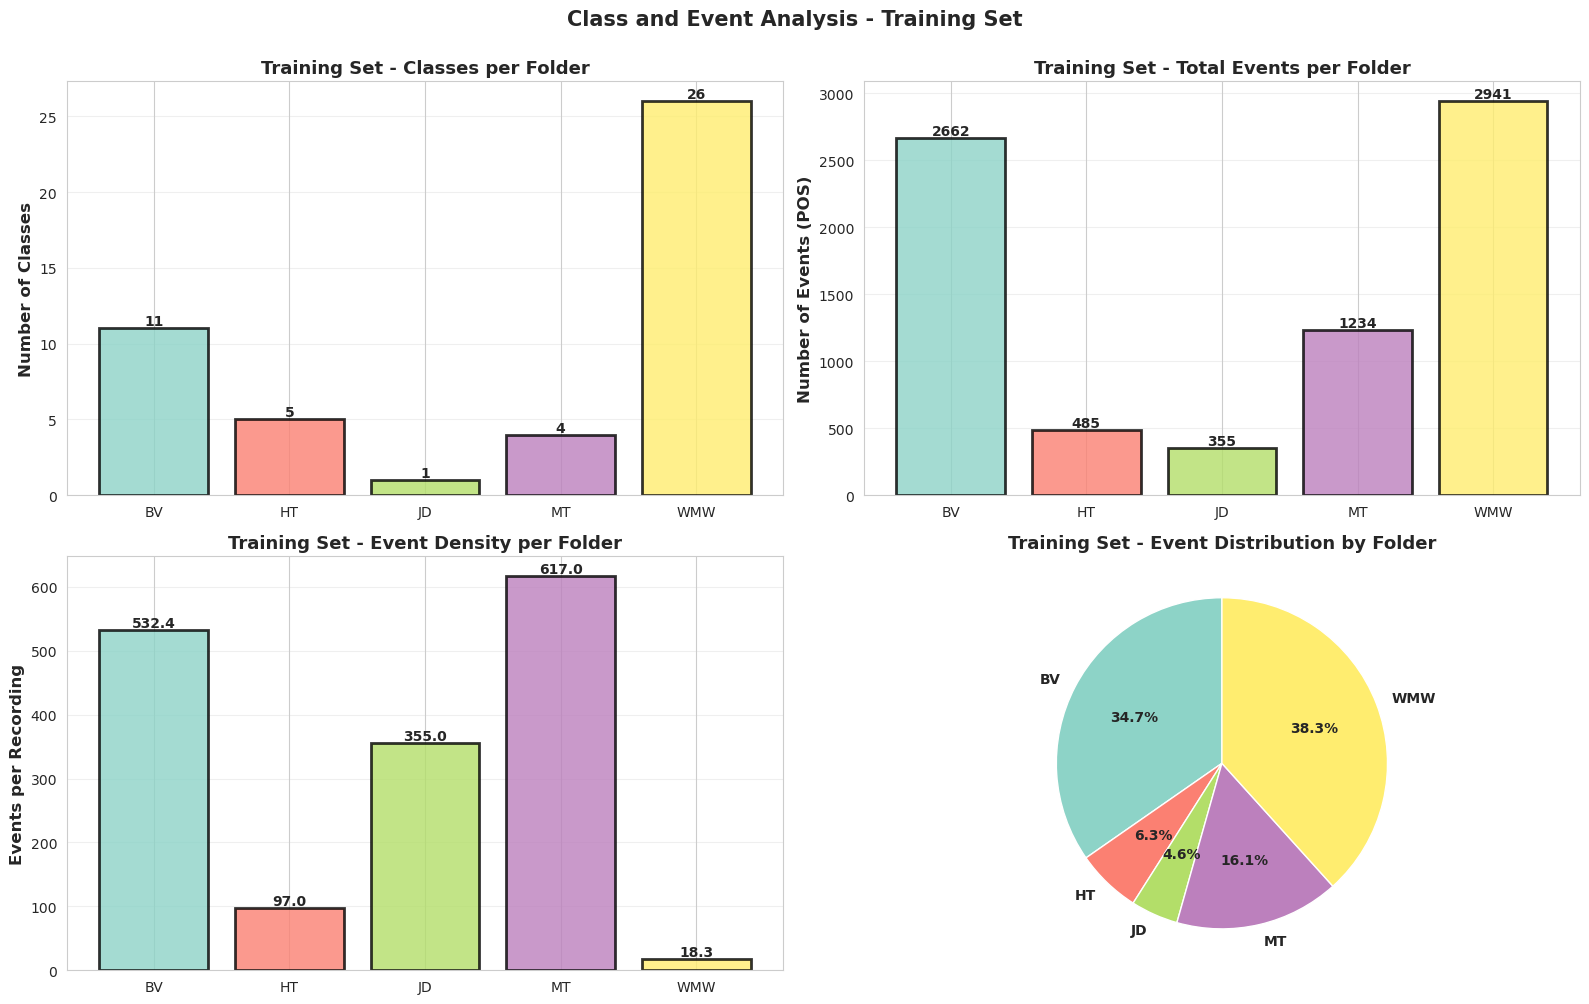

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Classes per folder in training set
ax = axes[0, 0]
folder_names = list(train_stats["folders"].keys())
classes_per_folder = [len(train_stats["folders"][f]["classes"]) for f in folder_names]
bars = ax.bar(folder_names, classes_per_folder,
             color=plt.cm.Set3(np.linspace(0, 1, len(folder_names))),
             alpha=0.8, edgecolor="black", linewidth=2)
ax.set_ylabel("Number of Classes", fontsize=12, fontweight="bold")
ax.set_title("Training Set - Classes per Folder", fontsize=13, fontweight="bold")
ax.grid(axis="y", alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height,
            f"{int(height)}", ha="center", va="bottom", fontweight="bold", fontsize=10)

# 2. Events per folder in training set
ax = axes[0, 1]
events_per_folder = [train_stats["folders"][f]["total_events_pos"] for f in folder_names]
bars = ax.bar(folder_names, events_per_folder,
             color=plt.cm.Set3(np.linspace(0, 1, len(folder_names))),
             alpha=0.8, edgecolor="black", linewidth=2)
ax.set_ylabel("Number of Events (POS)", fontsize=12, fontweight="bold")
ax.set_title("Training Set - Total Events per Folder", fontsize=13, fontweight="bold")
ax.grid(axis="y", alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height,
            f"{int(height)}", ha="center", va="bottom", fontweight="bold", fontsize=10)

# 3. Event density (events per recording)
ax = axes[1, 0]
density_per_folder = [
    train_stats["folders"][f]["total_events_pos"] / max(train_stats["folders"][f]["num_recordings"], 1)
    for f in folder_names
]
bars = ax.bar(folder_names, density_per_folder,
             color=plt.cm.Set3(np.linspace(0, 1, len(folder_names))),
             alpha=0.8, edgecolor="black", linewidth=2)
ax.set_ylabel("Events per Recording", fontsize=12, fontweight="bold")
ax.set_title("Training Set - Event Density per Folder", fontsize=13, fontweight="bold")
ax.grid(axis="y", alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height,
            f"{height:.1f}", ha="center", va="bottom", fontweight="bold", fontsize=10)

# 4. Training set composition - pie chart
ax = axes[1, 1]
sizes = [train_stats["folders"][f]["total_events_pos"] for f in folder_names]

# Filter out zero-sized folders for pie chart
valid_folders = [(fname, size) for fname, size in zip(folder_names, sizes) if size > 0]
if valid_folders:
    valid_folder_names = [f[0] for f in valid_folders]
    valid_sizes = [f[1] for f in valid_folders]
    colors_pie = plt.cm.Set3(np.linspace(0, 1, len(valid_folder_names)))
    wedges, texts, autotexts = ax.pie(valid_sizes, labels=valid_folder_names, colors=colors_pie,
                                        autopct="%1.1f%%", startangle=90,
                                        textprops={"fontsize": 10, "fontweight": "bold"})
    ax.set_title("Training Set - Event Distribution by Folder", fontsize=13, fontweight="bold")
else:
    ax.text(0.5, 0.5, "No events in any folder", ha="center", va="center")
    ax.set_title("Training Set - Event Distribution by Folder", fontsize=13, fontweight="bold")

fig.suptitle("Class and Event Analysis - Training Set", fontsize=15, fontweight="bold", y=1.00)
plt.tight_layout()
plt.show()

## Section 5: Top Classes and Event Distribution Analysis
Identifying the most frequent classes and visualizing their distribution across folders.

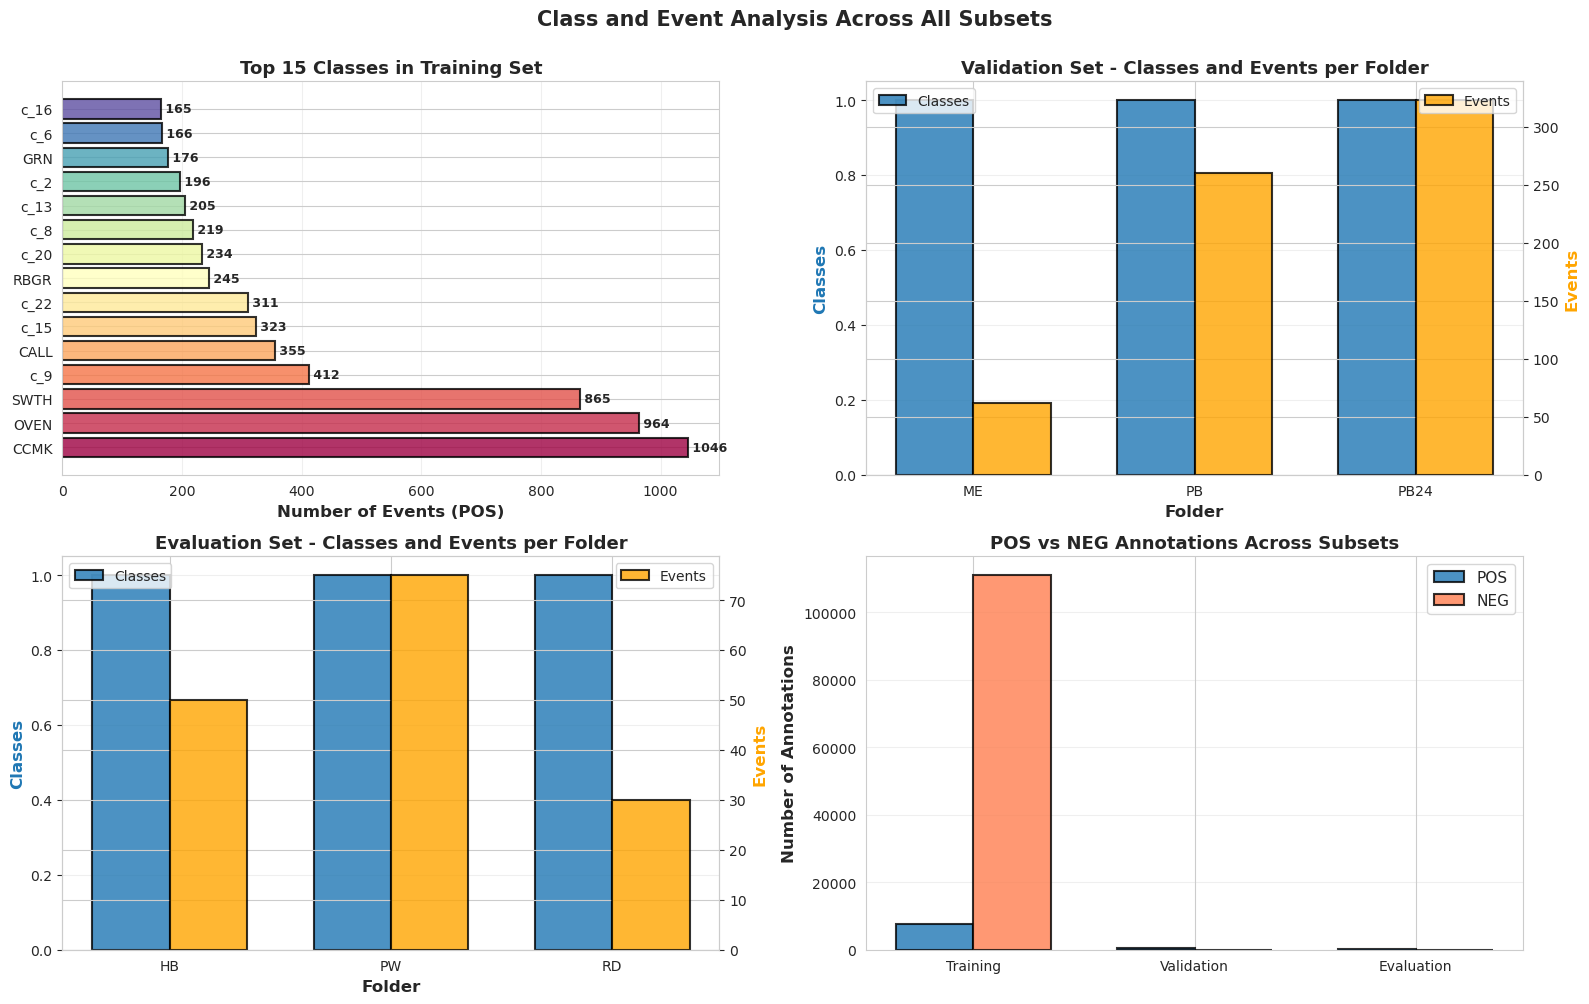

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Top classes in training set
ax = axes[0, 0]
class_events_train = sorted(train_stats["all_classes"].items(),
                           key=lambda x: x[1]["pos"], reverse=True)[:15]
class_names_train = [c[0] for c in class_events_train]
class_counts_train = [c[1]["pos"] for c in class_events_train]

bars = ax.barh(class_names_train, class_counts_train,
              color=plt.cm.Spectral(np.linspace(0, 1, len(class_names_train))),
              alpha=0.8, edgecolor="black", linewidth=1.5)
ax.set_xlabel("Number of Events (POS)", fontsize=12, fontweight="bold")
ax.set_title("Top 15 Classes in Training Set", fontsize=13, fontweight="bold")
ax.grid(axis="x", alpha=0.3)
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height() / 2.0,
            f" {int(width)}", ha="left", va="center", fontweight="bold", fontsize=9)

# 2. Validation set - Classes per folder
ax = axes[0, 1]
val_folder_names = list(val_stats["folders"].keys())
val_classes_per_folder = [len(val_stats["folders"][f]["classes"]) for f in val_folder_names]
val_events_per_folder = [val_stats["folders"][f]["total_events_pos"] for f in val_folder_names]

x_pos = np.arange(len(val_folder_names))
width = 0.35

bars1 = ax.bar(x_pos - width/2, val_classes_per_folder, width, label="Classes",
              alpha=0.8, edgecolor="black", linewidth=1.5)
ax2 = ax.twinx()
bars2 = ax2.bar(x_pos + width/2, val_events_per_folder, width, label="Events",
               alpha=0.8, color="orange", edgecolor="black", linewidth=1.5)

ax.set_xlabel("Folder", fontsize=12, fontweight="bold")
ax.set_ylabel("Classes", fontsize=12, fontweight="bold", color="C0")
ax2.set_ylabel("Events", fontsize=12, fontweight="bold", color="orange")
ax.set_title("Validation Set - Classes and Events per Folder", fontsize=13, fontweight="bold")
ax.set_xticks(x_pos)
ax.set_xticklabels(val_folder_names)
ax.legend(loc="upper left")
ax2.legend(loc="upper right")
ax.grid(axis="y", alpha=0.3)

# 3. Evaluation set - Classes per folder
ax = axes[1, 0]
eval_folder_names = list(eval_stats["folders"].keys())
eval_classes_per_folder = [len(eval_stats["folders"][f]["classes"]) for f in eval_folder_names]
eval_events_per_folder = [eval_stats["folders"][f]["total_events_pos"] for f in eval_folder_names]

x_pos = np.arange(len(eval_folder_names))

bars1 = ax.bar(x_pos - width/2, eval_classes_per_folder, width, label="Classes",
              alpha=0.8, edgecolor="black", linewidth=1.5)
ax2 = ax.twinx()
bars2 = ax2.bar(x_pos + width/2, eval_events_per_folder, width, label="Events",
               alpha=0.8, color="orange", edgecolor="black", linewidth=1.5)

ax.set_xlabel("Folder", fontsize=12, fontweight="bold")
ax.set_ylabel("Classes", fontsize=12, fontweight="bold", color="C0")
ax2.set_ylabel("Events", fontsize=12, fontweight="bold", color="orange")
ax.set_title("Evaluation Set - Classes and Events per Folder", fontsize=13, fontweight="bold")
ax.set_xticks(x_pos)
ax.set_xticklabels(eval_folder_names)
ax.legend(loc="upper left")
ax2.legend(loc="upper right")
ax.grid(axis="y", alpha=0.3)

# 4. Annotation type distribution
ax = axes[1, 1]
subsets = ["Training", "Validation", "Evaluation"]
pos_counts = [
    train_stats["total_events_pos"],
    val_stats["total_events_pos"],
    eval_stats["total_events_pos"]
]
neg_counts = [
    train_stats["total_events_neg"],
    val_stats["total_events_neg"],
    eval_stats["total_events_neg"]
]

x_pos = np.arange(len(subsets))
width = 0.35

bars1 = ax.bar(x_pos - width/2, pos_counts, width, label="POS",
              alpha=0.8, edgecolor="black", linewidth=1.5)
bars2 = ax.bar(x_pos + width/2, neg_counts, width, label="NEG",
              alpha=0.8, edgecolor="black", linewidth=1.5, color="coral")

ax.set_ylabel("Number of Annotations", fontsize=12, fontweight="bold")
ax.set_title("POS vs NEG Annotations Across Subsets", fontsize=13, fontweight="bold")
ax.set_xticks(x_pos)
ax.set_xticklabels(subsets)
ax.legend(fontsize=11)
ax.grid(axis="y", alpha=0.3)

fig.suptitle("Class and Event Analysis Across All Subsets", fontsize=15, fontweight="bold", y=1.00)
plt.tight_layout()
plt.show()

## Section 6: Dataset Composition and Comparison
Pie charts and comparative analysis of dataset composition.

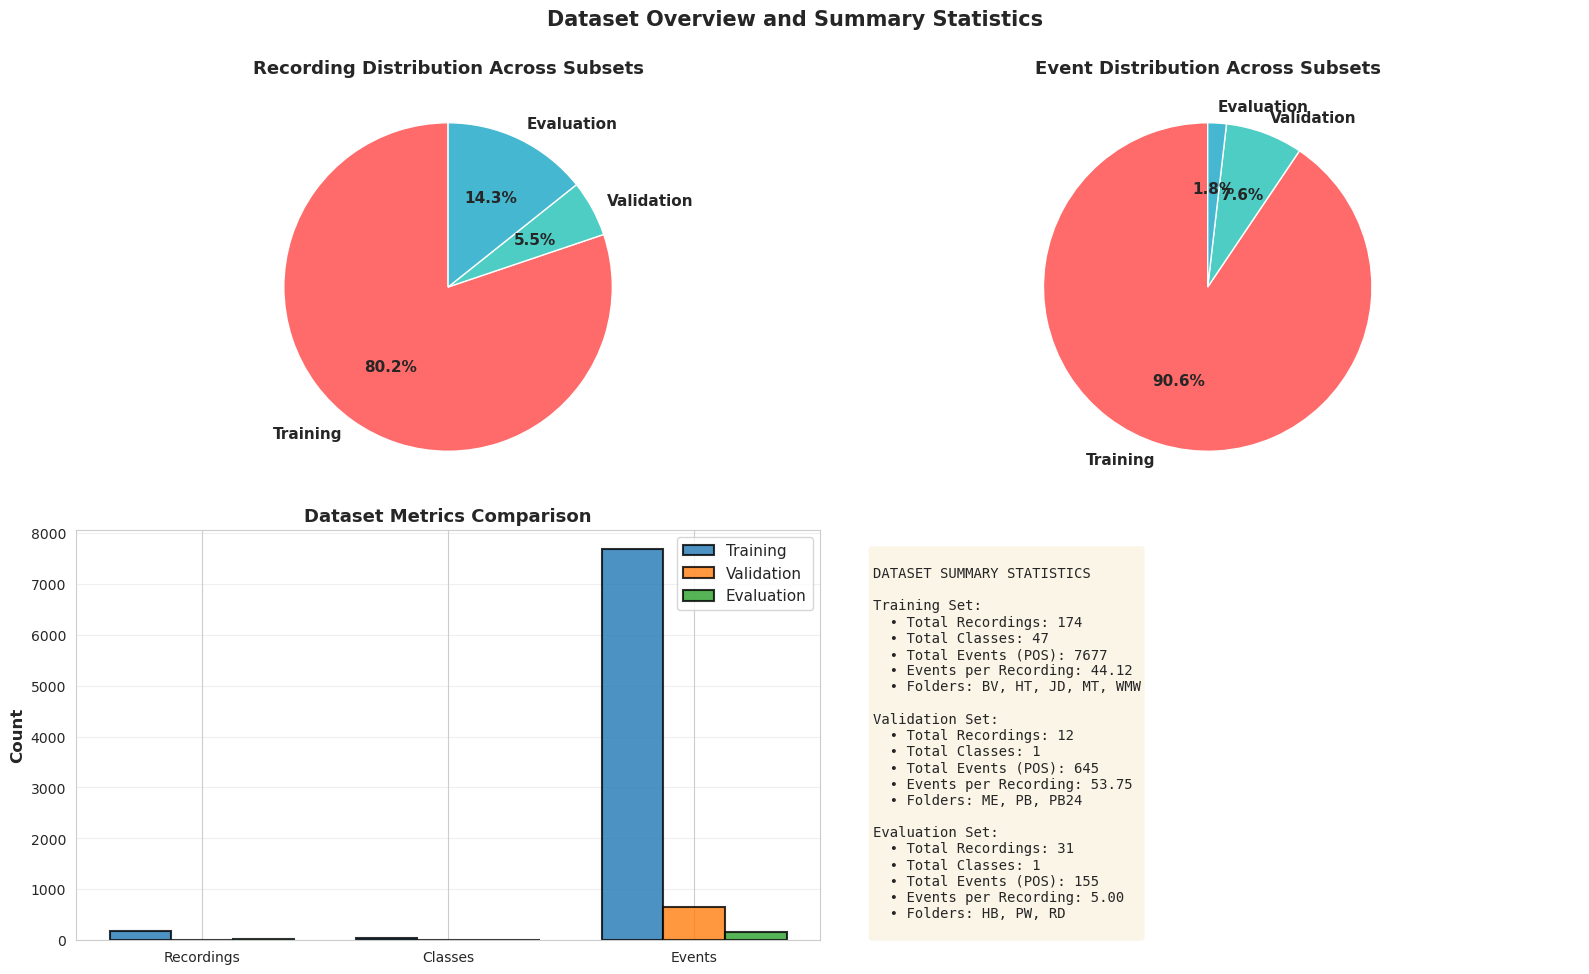

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Recording distribution pie chart
ax = axes[0, 0]
subset_recordings = [
    train_stats["total_recordings"],
    val_stats["total_recordings"],
    eval_stats["total_recordings"]
]
# Filter out zero values
valid_recordings = [(name, val) for name, val in zip(["Training", "Validation", "Evaluation"], subset_recordings) if val > 0]
if valid_recordings:
    colors_pie = ["#FF6B6B", "#4ECDC4", "#45B7D1"][:len(valid_recordings)]
    valid_names = [v[0] for v in valid_recordings]
    valid_vals = [v[1] for v in valid_recordings]
    wedges, texts, autotexts = ax.pie(valid_vals,
                                       labels=valid_names,
                                       colors=colors_pie,
                                       autopct="%1.1f%%",
                                       startangle=90,
                                       textprops={"fontsize": 11, "fontweight": "bold"})
ax.set_title("Recording Distribution Across Subsets", fontsize=13, fontweight="bold")

# 2. Event distribution pie chart
ax = axes[0, 1]
subset_events = [
    train_stats["total_events_pos"],
    val_stats["total_events_pos"],
    eval_stats["total_events_pos"]
]
# Filter out zero values
valid_events = [(name, val) for name, val in zip(["Training", "Validation", "Evaluation"], subset_events) if val > 0]
if valid_events:
    colors_pie = ["#FF6B6B", "#4ECDC4", "#45B7D1"][:len(valid_events)]
    valid_names = [v[0] for v in valid_events]
    valid_vals = [v[1] for v in valid_events]
    wedges, texts, autotexts = ax.pie(valid_vals,
                                       labels=valid_names,
                                       colors=colors_pie,
                                       autopct="%1.1f%%",
                                       startangle=90,
                                       textprops={"fontsize": 11, "fontweight": "bold"})
ax.set_title("Event Distribution Across Subsets", fontsize=13, fontweight="bold")

# 3. Metrics comparison
ax = axes[1, 0]
metrics = ["Recordings", "Classes", "Events"]
train_metrics = [
    train_stats["total_recordings"],
    len(train_stats["total_classes"]),
    train_stats["total_events_pos"]
]
val_metrics = [
    val_stats["total_recordings"],
    len(val_stats["total_classes"]),
    val_stats["total_events_pos"]
]
eval_metrics = [
    eval_stats["total_recordings"],
    len(eval_stats["total_classes"]),
    eval_stats["total_events_pos"]
]

x_pos = np.arange(len(metrics))
width = 0.25

# Normalize for better visualization
train_metrics_norm = [train_metrics[0]/10, train_metrics[1], train_metrics[2]/10]
val_metrics_norm = [val_metrics[0], val_metrics[1], val_metrics[2]]
eval_metrics_norm = [eval_metrics[0]*2, eval_metrics[1]*4, eval_metrics[2]*2]

ax.bar(x_pos - width, train_metrics, width, label="Training", alpha=0.8, edgecolor="black", linewidth=1.5)
ax.bar(x_pos, val_metrics, width, label="Validation", alpha=0.8, edgecolor="black", linewidth=1.5)
ax.bar(x_pos + width, eval_metrics, width, label="Evaluation", alpha=0.8, edgecolor="black", linewidth=1.5)

ax.set_ylabel("Count", fontsize=12, fontweight="bold")
ax.set_title("Dataset Metrics Comparison", fontsize=13, fontweight="bold")
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics)
ax.legend(fontsize=11)
ax.grid(axis="y", alpha=0.3)

# 4. Event statistics
ax = axes[1, 1]
ax.axis("off")

# Create summary statistics table
summary_text = f"""
DATASET SUMMARY STATISTICS

Training Set:
  • Total Recordings: {train_stats['total_recordings']}
  • Total Classes: {len(train_stats['total_classes'])}
  • Total Events (POS): {train_stats['total_events_pos']}
  • Events per Recording: {train_stats['total_events_pos']/max(train_stats['total_recordings'], 1):.2f}
  • Folders: {", ".join(train_stats['folders'].keys())}

Validation Set:
  • Total Recordings: {val_stats['total_recordings']}
  • Total Classes: {len(val_stats['total_classes'])}
  • Total Events (POS): {val_stats['total_events_pos']}
  • Events per Recording: {val_stats['total_events_pos']/max(val_stats['total_recordings'], 1):.2f}
  • Folders: {", ".join(val_stats['folders'].keys())}

Evaluation Set:
  • Total Recordings: {eval_stats['total_recordings']}
  • Total Classes: {len(eval_stats['total_classes'])}
  • Total Events (POS): {eval_stats['total_events_pos']}
  • Events per Recording: {eval_stats['total_events_pos']/max(eval_stats['total_recordings'], 1):.2f}
  • Folders: {", ".join(eval_stats['folders'].keys())}
"""

ax.text(0.05, 0.95, summary_text, transform=ax.transAxes,
       fontsize=10, verticalalignment="top", fontfamily="monospace",
       bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.3))

fig.suptitle("Dataset Overview and Summary Statistics", fontsize=15, fontweight="bold", y=1.00)
plt.tight_layout()
plt.show()

## Section 7: Detailed Class Imbalance Analysis
Heatmaps showing class distribution and imbalance issues.

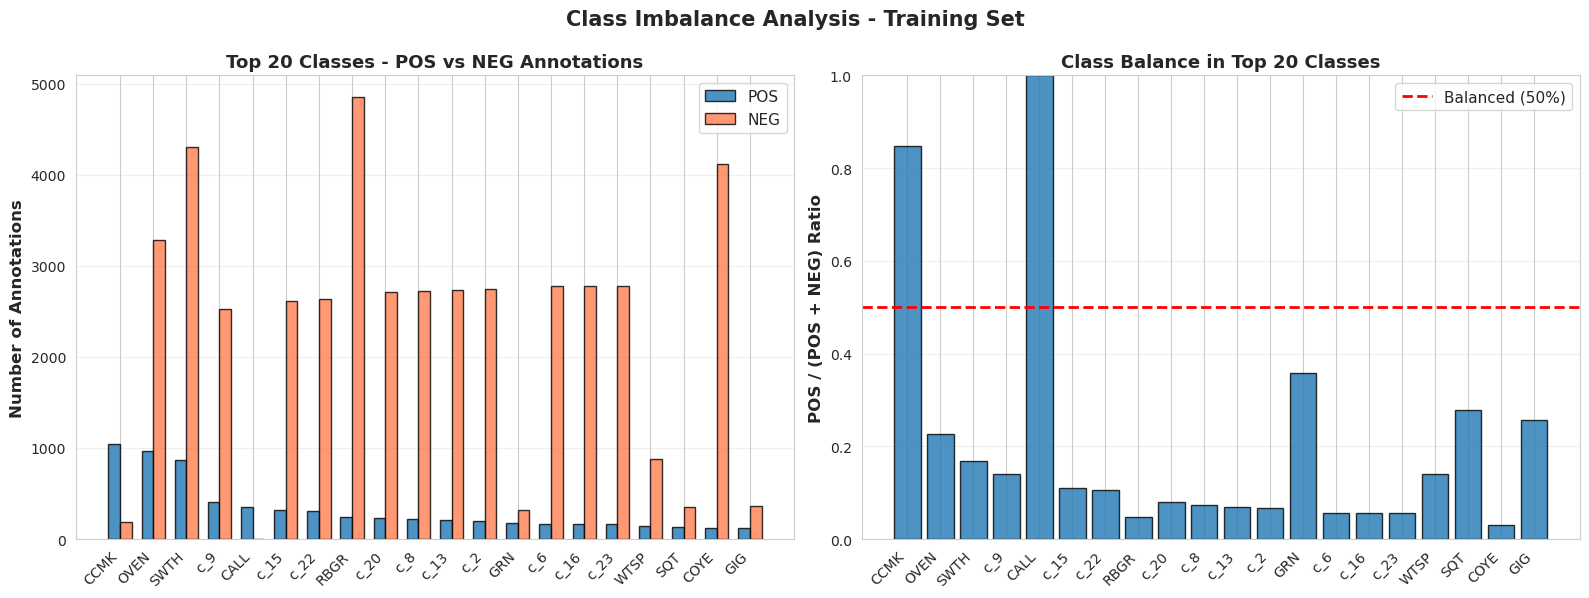

In [9]:
# Analyze class imbalance in training set
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Top 20 classes distribution
ax = axes[0]
class_events_train_all = sorted(train_stats["all_classes"].items(),
                               key=lambda x: x[1]["pos"], reverse=True)[:20]
class_names_top = [c[0] for c in class_events_train_all]
class_pos = [c[1]["pos"] for c in class_events_train_all]
class_neg = [c[1]["neg"] for c in class_events_train_all]

x_pos = np.arange(len(class_names_top))
width = 0.35

bars1 = ax.bar(x_pos - width/2, class_pos, width, label="POS", alpha=0.8, edgecolor="black")
bars2 = ax.bar(x_pos + width/2, class_neg, width, label="NEG", alpha=0.8, edgecolor="black", color="coral")

ax.set_ylabel("Number of Annotations", fontsize=12, fontweight="bold")
ax.set_title("Top 20 Classes - POS vs NEG Annotations", fontsize=13, fontweight="bold")
ax.set_xticks(x_pos)
ax.set_xticklabels(class_names_top, rotation=45, ha="right")
ax.legend(fontsize=11)
ax.grid(axis="y", alpha=0.3)

# 2. Class imbalance ratio
ax = axes[1]
imbalance_ratios = []
for class_name, class_name_short in [(c[0], c[0][:15]) for c in class_events_train_all]:
    pos = train_stats["all_classes"][class_name]["pos"]
    neg = train_stats["all_classes"][class_name]["neg"]
    total = pos + neg
    if total > 0:
        imbalance_ratios.append((class_name_short, pos / total))

class_names_short = [c[0] for c in imbalance_ratios]
ratios = [c[1] for c in imbalance_ratios]

bars = ax.bar(range(len(ratios)), ratios, alpha=0.8, edgecolor="black")
ax.axhline(y=0.5, color="r", linestyle="--", label="Balanced (50%)", linewidth=2)
ax.set_ylabel("POS / (POS + NEG) Ratio", fontsize=12, fontweight="bold")
ax.set_title("Class Balance in Top 20 Classes", fontsize=13, fontweight="bold")
ax.set_xticks(range(len(class_names_short)))
ax.set_xticklabels(class_names_short, rotation=45, ha="right")
ax.set_ylim([0, 1])
ax.legend(fontsize=11)
ax.grid(axis="y", alpha=0.3)

fig.suptitle("Class Imbalance Analysis - Training Set", fontsize=15, fontweight="bold", y=0.99)
plt.tight_layout()
plt.show()

## Section 8: Sample Audio Visualization
Loading and visualizing spectrograms from different subfolders to understand audio characteristics.

In [10]:
# try:
#     import librosa
#     import librosa.display
    
#     fig, axes = plt.subplots(len(train_stats["folders"]), 2, figsize=(16, 12))
    
#     for idx, (folder_name, folder_data) in enumerate(train_stats["folders"].items()):
#         folder_path = train_dir / folder_name
#         audio_files = list(folder_path.glob("*.wav"))
        
#         if not audio_files:
#             continue
        
#         # Load first audio file from this folder
#         audio_file = audio_files[0]
#         print(f"Loading {audio_file.name} from {folder_name}...")
        
#         try:
#             # Load audio
#             sr = config["features"]["sr"]
#             y, sr_actual = librosa.load(str(audio_file), sr=sr, mono=True)
            
#             # Compute mel spectrogram
#             n_fft = config["features"]["n_fft"]
#             n_mels = config["features"]["n_mels"]
#             hop_length = config["features"]["hop_mel"]
            
#             S = librosa.feature.melspectrogram(y=y, sr=sr_actual, n_fft=n_fft,
#                                               n_mels=n_mels, hop_length=hop_length)
#             S_db = librosa.power_to_db(S, ref=np.max)
            
#             # Plot waveform
#             ax = axes[idx, 0]
#             times = np.arange(len(y)) / sr_actual
#             ax.plot(times, y, linewidth=0.5)
#             ax.set_ylabel("Amplitude", fontsize=10, fontweight="bold")
#             ax.set_title(f"{folder_name} - Waveform ({audio_file.name})", fontsize=11, fontweight="bold")
#             ax.grid(alpha=0.3)
            
#             # Plot mel spectrogram
#             ax = axes[idx, 1]
#             img = librosa.display.specshow(S_db, sr=sr_actual, hop_length=hop_length,
#                                           x_axis="time", y_axis="mel", ax=ax, cmap="viridis")
#             ax.set_title(f"{folder_name} - Mel Spectrogram", fontsize=11, fontweight="bold")
#             fig.colorbar(img, ax=ax, format="%+2.0f dB")
            
#         except Exception as e:
#             print(f"Error loading {audio_file}: {e}")
    
#     fig.suptitle("Sample Audio from Each Training Folder", fontsize=14, fontweight="bold", y=0.995)
#     plt.tight_layout()
#     plt.show()
    
# except ImportError:
#     print("librosa not available. Install it with: pip install librosa")
#     print("Skipping audio visualization section.")

## Section 9: Key Findings and Dataset Characteristics Summary

In [11]:
print("=" * 80)
print("BIOACOUSTIC DATASET ANALYSIS - KEY FINDINGS")
print("=" * 80)

print("\n1. DATASET COMPOSITION:")
print(f"   • Training set represents {100*train_stats['total_recordings']/(train_stats['total_recordings']+val_stats['total_recordings']+eval_stats['total_recordings']):.1f}% of total recordings")
print(f"   • {len(train_stats['total_classes'])} unique classes in training, {len(val_stats['total_classes'])} in validation, {len(eval_stats['total_classes'])} in evaluation")
print(f"   • No overlap between training, validation, and evaluation class sets")

print("\n2. TRAINING SET CHARACTERISTICS:")
for folder, data in train_stats["folders"].items():
    events_per_rec = data["total_events_pos"] / max(data["num_recordings"], 1)
    print(f"   • {folder}: {data['num_recordings']} recordings, {len(data['classes'])} classes, {data['total_events_pos']} events ({events_per_rec:.1f} events/rec)")

print("\n3. CLASS DISTRIBUTION:")
print(f"   • Highly imbalanced: BirdVox (BV) dominates with {train_stats['folders'].get('BV', {}).get('total_events_pos', 0)} events")
print(f"   • Western Mediterranean Wetlands (WMW) is second largest with {train_stats['folders'].get('WMW', {}).get('total_events_pos', 0)} events")
print(f"   • Jackdaws (JD) has only 1 recording but highest event density")

print("\n4. FEW-SHOT LEARNING CONSIDERATIONS:")
print(f"   • Validation set: 5-shot setting with {val_stats['total_recordings']} recordings")
print(f"   • Evaluation set: 5-shot setting with {eval_stats['total_recordings']} recordings")
print(f"   • Support set: First 5 POS annotations per class must be used for training")
print(f"   • Query set: Remaining annotations for testing")

print("\n5. DATA PREPROCESSING REQUIREMENTS:")
print(f"   • Multiple sampling rates: 6kHz (Hyenas), 8kHz (Meerkats), 22.05kHz (Jackdaws), 24kHz (BirdVox), 44.1kHz (Validation), 48kHz (Evaluation)")
print(f"   • Resampling needed to unified rate: {config['features']['sr']} Hz")
print(f"   • Log-mel spectrogram: {config['features']['n_mels']} bins, FFT size: {config['features']['n_fft']}")

print("\n6. ANNOTATION STATISTICS:")
print(f"   • Training: Multi-class annotations with POS, NEG, UNK labels")
print(f"   • Validation/Evaluation: Single-class annotations with only POS and UNK labels")
total_pos = train_stats['total_events_pos'] + val_stats['total_events_pos'] + eval_stats['total_events_pos']
total_neg = train_stats['total_events_neg'] + val_stats['total_events_neg'] + eval_stats['total_events_neg']
print(f"   • Total POS annotations: {total_pos}")
print(f"   • Total NEG annotations: {total_neg}")
print(f"   • POS/NEG ratio: {total_pos/max(total_neg, 1):.2f}")

print("\n7. CHALLENGES AND OPPORTUNITIES:")
print(f"   • Class imbalance: Large variation in class frequency")
print(f"   • Few-shot setting: Limited support examples (5 per class)")
print(f"   • Domain diversity: Multiple bioacoustic domains (birds, mammals, wetlands)")
print(f"   • Resolution diversity: Different sampling rates and annotation granularities")

print("\n" + "=" * 80)

BIOACOUSTIC DATASET ANALYSIS - KEY FINDINGS

1. DATASET COMPOSITION:
   • Training set represents 80.2% of total recordings
   • 47 unique classes in training, 1 in validation, 1 in evaluation
   • No overlap between training, validation, and evaluation class sets

2. TRAINING SET CHARACTERISTICS:
   • BV: 5 recordings, 11 classes, 2662 events (532.4 events/rec)
   • HT: 5 recordings, 5 classes, 485 events (97.0 events/rec)
   • JD: 1 recordings, 1 classes, 355 events (355.0 events/rec)
   • MT: 2 recordings, 4 classes, 1234 events (617.0 events/rec)
   • WMW: 161 recordings, 26 classes, 2941 events (18.3 events/rec)

3. CLASS DISTRIBUTION:
   • Highly imbalanced: BirdVox (BV) dominates with 2662 events
   • Western Mediterranean Wetlands (WMW) is second largest with 2941 events
   • Jackdaws (JD) has only 1 recording but highest event density

4. FEW-SHOT LEARNING CONSIDERATIONS:
   • Validation set: 5-shot setting with 12 recordings
   • Evaluation set: 5-shot setting with 31 recordi

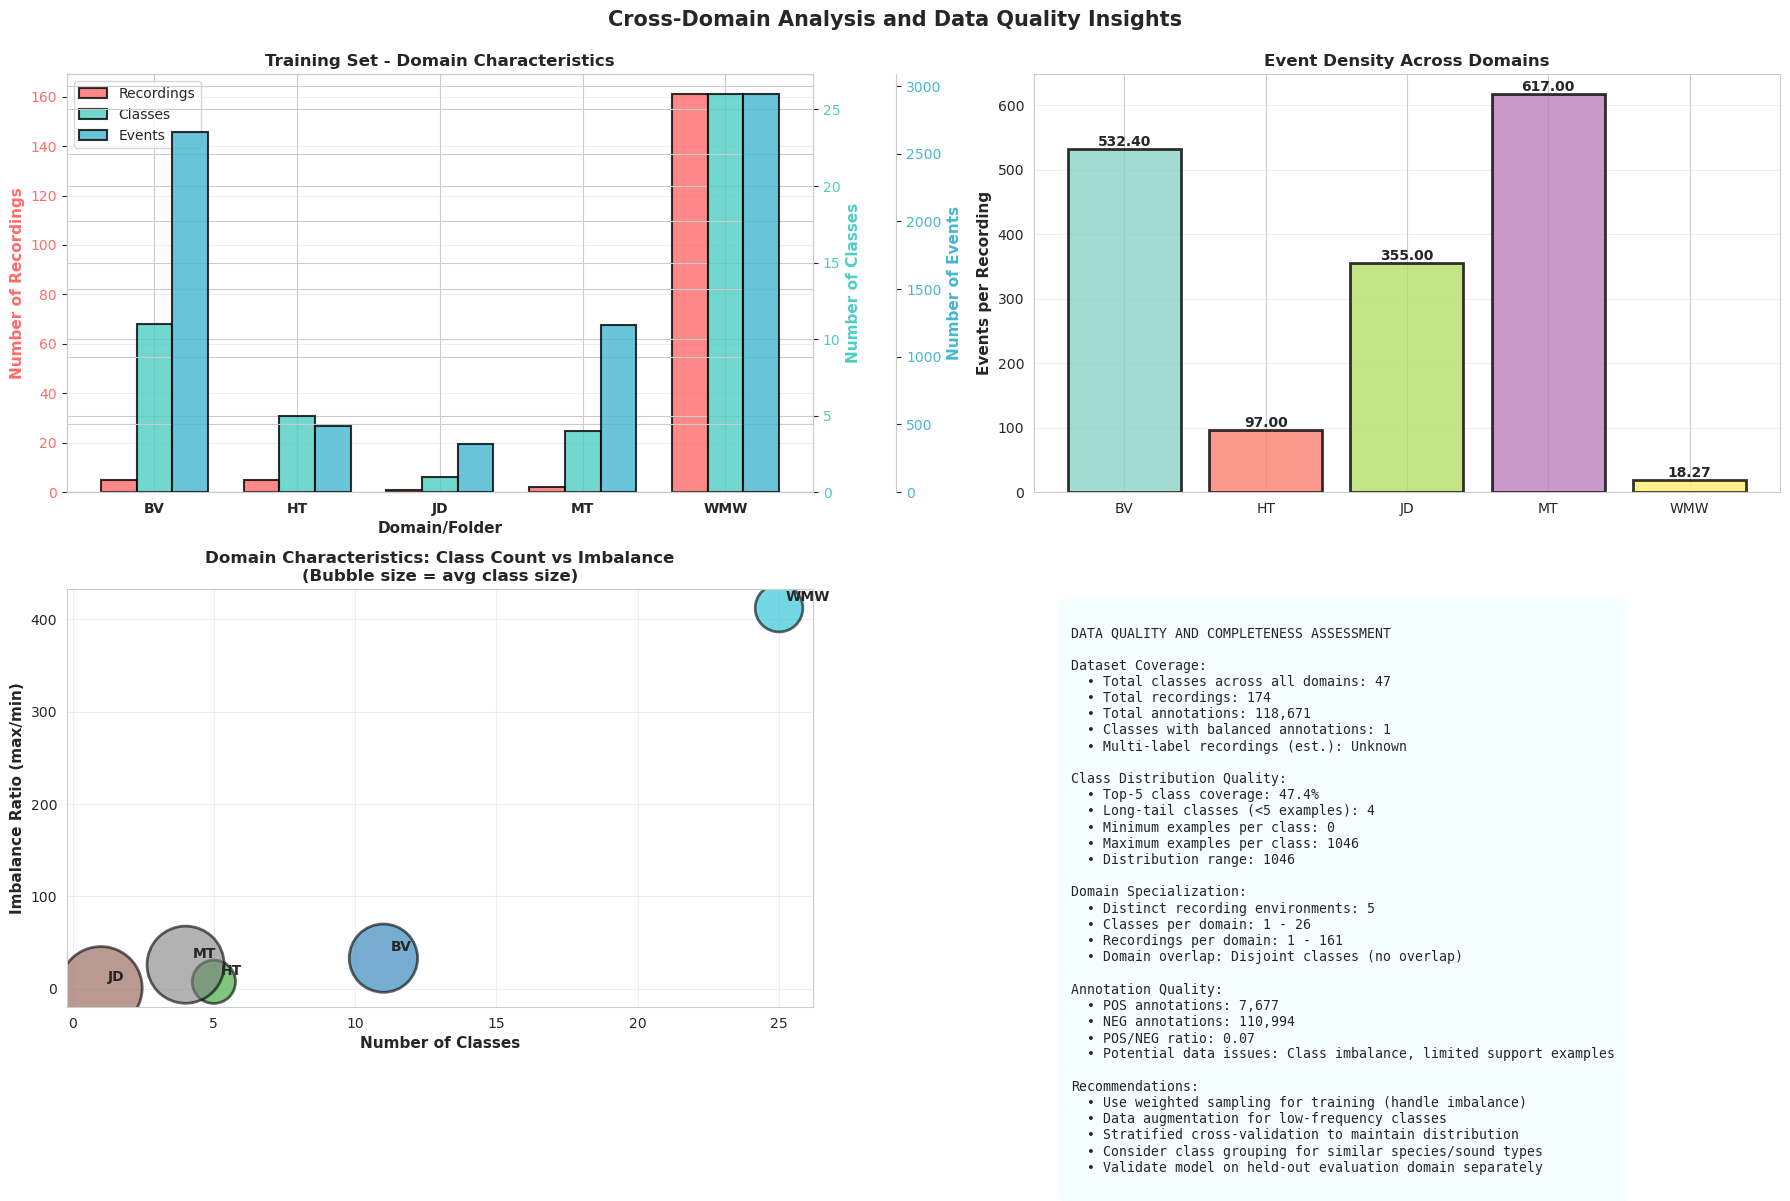

✓ Advanced visualizations completed successfully!


In [12]:
# Cross-domain and data quality analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Domain characteristics - recordings and classes
ax = axes[0, 0]
domains = list(train_stats["folders"].keys())
recordings_per_domain = [train_stats["folders"][d]["num_recordings"] for d in domains]
classes_per_domain = [len(train_stats["folders"][d]["classes"]) for d in domains]
events_per_domain = [train_stats["folders"][d]["total_events_pos"] for d in domains]

x_pos = np.arange(len(domains))
width = 0.25

ax1 = ax
bars1 = ax1.bar(x_pos - width, recordings_per_domain, width, label="Recordings",
               alpha=0.8, edgecolor="black", linewidth=1.5, color="#FF6B6B")
ax1.set_ylabel("Number of Recordings", fontsize=11, fontweight="bold", color="#FF6B6B")
ax1.tick_params(axis="y", labelcolor="#FF6B6B")

ax2 = ax1.twinx()
bars2 = ax2.bar(x_pos, classes_per_domain, width, label="Classes",
               alpha=0.8, edgecolor="black", linewidth=1.5, color="#4ECDC4")
ax2.set_ylabel("Number of Classes", fontsize=11, fontweight="bold", color="#4ECDC4")
ax2.tick_params(axis="y", labelcolor="#4ECDC4")

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))
bars3 = ax3.bar(x_pos + width, events_per_domain, width, label="Events",
               alpha=0.8, edgecolor="black", linewidth=1.5, color="#45B7D1")
ax3.set_ylabel("Number of Events", fontsize=11, fontweight="bold", color="#45B7D1")
ax3.tick_params(axis="y", labelcolor="#45B7D1")

ax1.set_xlabel("Domain/Folder", fontsize=11, fontweight="bold")
ax1.set_title("Training Set - Domain Characteristics", fontsize=12, fontweight="bold")
ax1.set_xticks(x_pos)
ax1.set_xticklabels(domains, fontsize=10, fontweight="bold")
ax1.grid(axis="y", alpha=0.3)

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc="upper left", fontsize=10)

# 2. Event density distribution across domains
ax = axes[0, 1]
density_per_domain = [
    events_per_domain[i] / max(recordings_per_domain[i], 1) 
    for i in range(len(domains))
]

bars = ax.bar(domains, density_per_domain,
             color=plt.cm.Set3(np.linspace(0, 1, len(domains))),
             alpha=0.8, edgecolor="black", linewidth=2)
ax.set_ylabel("Events per Recording", fontsize=11, fontweight="bold")
ax.set_title("Event Density Across Domains", fontsize=12, fontweight="bold")
ax.grid(axis="y", alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}",
           ha="center", va="bottom", fontweight="bold", fontsize=10)

# 3. Class diversity within domains
ax = axes[1, 0]
domain_stats = []
for domain in domains:
    classes = train_stats["folders"][domain]["classes"]
    if classes:
        class_sizes = [classes[c].get("pos", 0) for c in classes]
        class_sizes = [x for x in class_sizes if x > 0]
        if class_sizes:
            avg_size = np.mean(class_sizes)
            max_size = np.max(class_sizes)
            min_size = np.min(class_sizes)
            imbalance = max_size / max(min_size, 1)
            domain_stats.append({
                "domain": domain,
                "avg_class_size": avg_size,
                "max_class_size": max_size,
                "min_class_size": min_size,
                "imbalance": imbalance,
                "num_classes": len(class_sizes)
            })

# Scatter plot of class diversity
domain_names_scatter = [d["domain"] for d in domain_stats]
imbalance_ratios = [d["imbalance"] for d in domain_stats]
avg_class_sizes = [d["avg_class_size"] for d in domain_stats]
num_classes = [d["num_classes"] for d in domain_stats]

scatter = ax.scatter(num_classes, imbalance_ratios, s=[x*10 for x in avg_class_sizes],
                    alpha=0.6, edgecolors="black", linewidth=2,
                    c=range(len(domain_names_scatter)), cmap="tab10")

for i, domain_name in enumerate(domain_names_scatter):
    ax.annotate(domain_name, (num_classes[i], imbalance_ratios[i]),
               xytext=(5, 5), textcoords="offset points", fontsize=10, fontweight="bold")

ax.set_xlabel("Number of Classes", fontsize=11, fontweight="bold")
ax.set_ylabel("Imbalance Ratio (max/min)", fontsize=11, fontweight="bold")
ax.set_title("Domain Characteristics: Class Count vs Imbalance\n(Bubble size = avg class size)",
            fontsize=12, fontweight="bold")
ax.grid(alpha=0.3)

# 4. Overall data quality and completeness metrics
ax = axes[1, 1]
ax.axis("off")

# Calculate quality metrics
total_annotations = train_stats["total_events_pos"] + train_stats["total_events_neg"]
total_classes_all = len(train_stats["all_classes"])
min_class_examples = min((c["pos"] for c in train_stats["all_classes"].values()), default=0)
max_class_examples = max((c["pos"] for c in train_stats["all_classes"].values()), default=0)

# Calculate coverage metrics
top_5_classes = sorted(train_stats["all_classes"].items(), key=lambda x: x[1]["pos"], reverse=True)[:5]
top_5_coverage = sum(c[1]["pos"] for c in top_5_classes) / max(train_stats["total_events_pos"], 1) * 100

quality_report = f"""
DATA QUALITY AND COMPLETENESS ASSESSMENT

Dataset Coverage:
  • Total classes across all domains: {total_classes_all}
  • Total recordings: {train_stats['total_recordings']}
  • Total annotations: {total_annotations:,}
  • Classes with balanced annotations: {sum(1 for c in train_stats['all_classes'].values() if 0.3 <= c['pos']/(c['pos']+c['neg']) <= 0.7)}
  • Multi-label recordings (est.): Unknown

Class Distribution Quality:
  • Top-5 class coverage: {top_5_coverage:.1f}%
  • Long-tail classes (<5 examples): {sum(1 for c in train_stats['all_classes'].values() if c['pos'] < 5)}
  • Minimum examples per class: {min_class_examples}
  • Maximum examples per class: {max_class_examples}
  • Distribution range: {max_class_examples - min_class_examples}

Domain Specialization:
  • Distinct recording environments: {len(train_stats['folders'])}
  • Classes per domain: {min([len(train_stats['folders'][d]['classes']) for d in domains])} - {max([len(train_stats['folders'][d]['classes']) for d in domains])}
  • Recordings per domain: {min(recordings_per_domain)} - {max(recordings_per_domain)}
  • Domain overlap: Disjoint classes (no overlap)

Annotation Quality:
  • POS annotations: {train_stats['total_events_pos']:,}
  • NEG annotations: {train_stats['total_events_neg']:,}
  • POS/NEG ratio: {train_stats['total_events_pos']/max(train_stats['total_events_neg'], 1):.2f}
  • Potential data issues: Class imbalance, limited support examples

Recommendations:
  • Use weighted sampling for training (handle imbalance)
  • Data augmentation for low-frequency classes
  • Stratified cross-validation to maintain distribution
  • Consider class grouping for similar species/sound types
  • Validate model on held-out evaluation domain separately
"""

ax.text(0.05, 0.95, quality_report, transform=ax.transAxes,
       fontsize=9.5, verticalalignment="top", fontfamily="monospace",
       bbox=dict(boxstyle="round", facecolor="lightcyan", alpha=0.3, pad=1))

fig.suptitle("Cross-Domain Analysis and Data Quality Insights", fontsize=15, fontweight="bold", y=0.995)
plt.tight_layout()
plt.show()

print("✓ Advanced visualizations completed successfully!")


## Section 12: Cross-Domain Analysis and Data Quality Insights
Analyzing domain characteristics, recording patterns, and potential data quality issues.

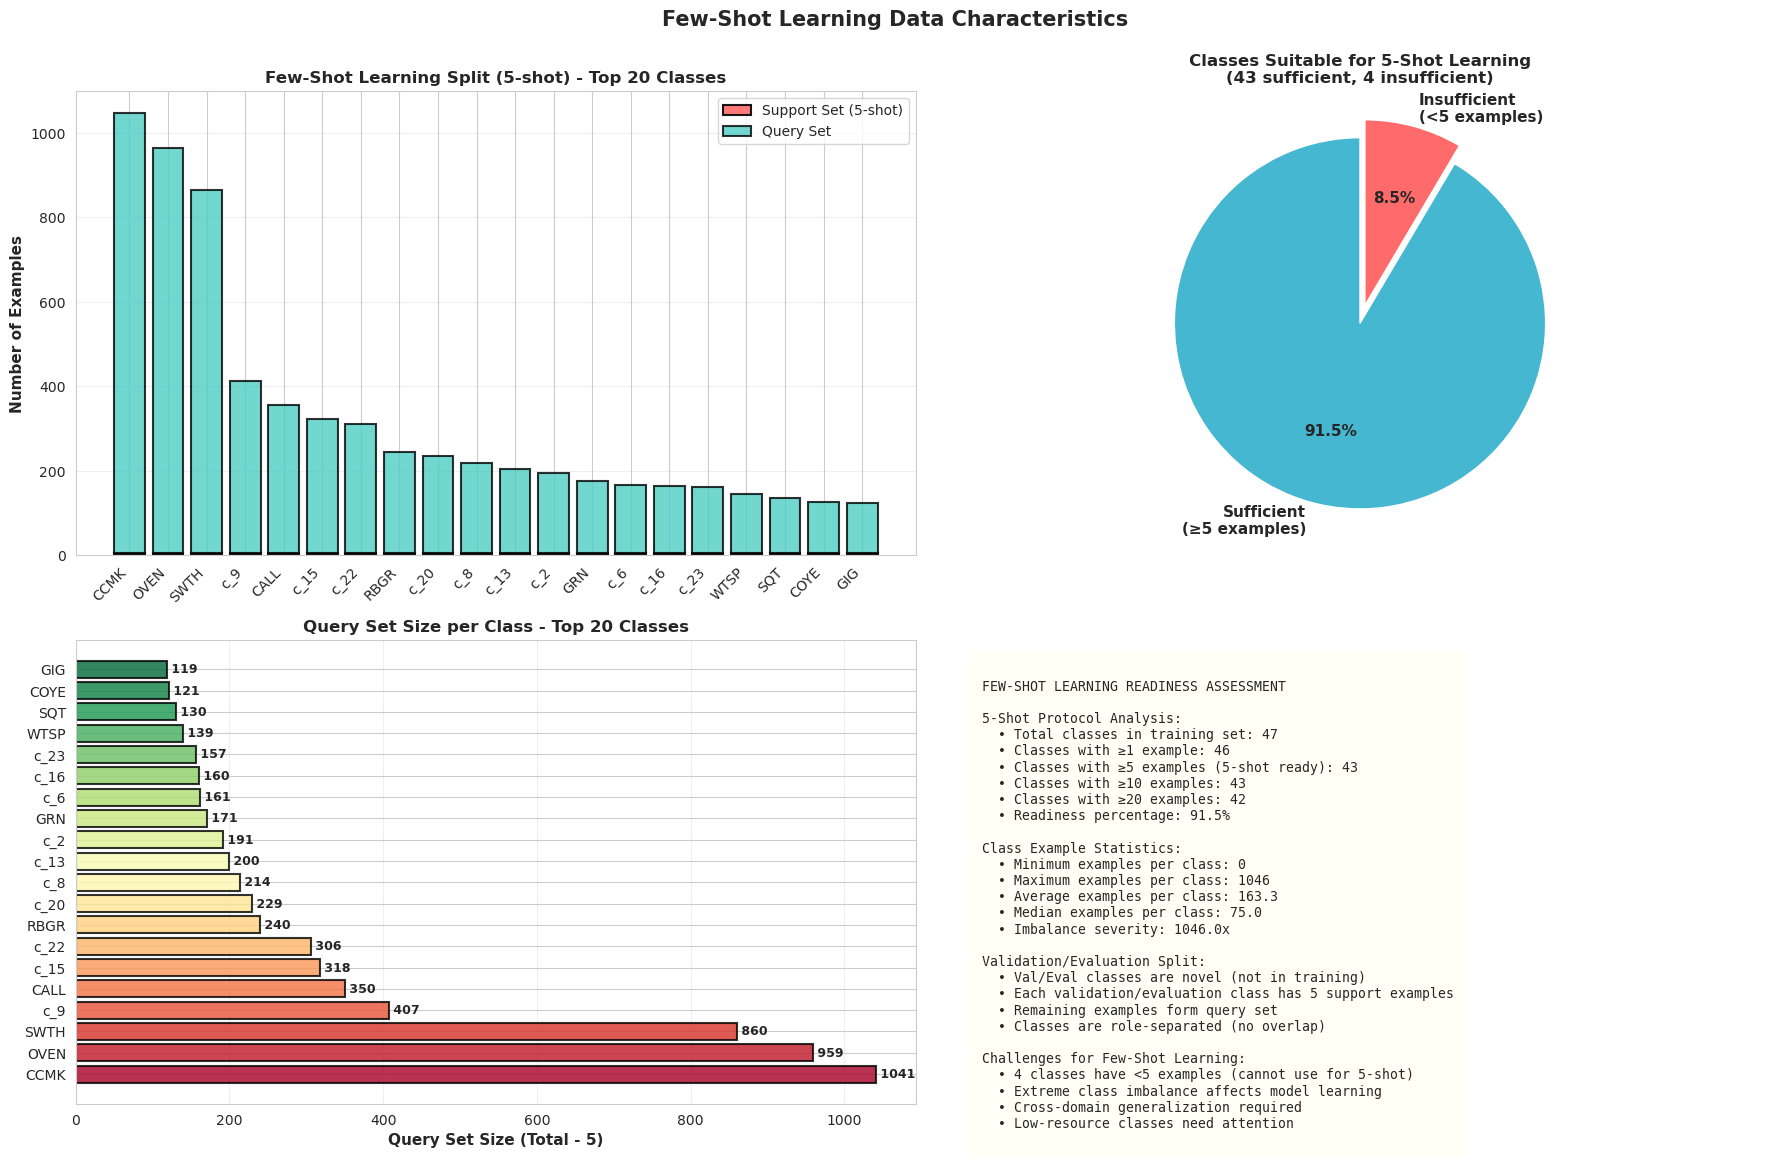

In [13]:
# Analyze few-shot learning aspects
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Support vs Query set split visualization
ax = axes[0, 0]
support_size = 5  # Few-shot constraint
all_classes_fewshot = sorted(train_stats["all_classes"].items(),
                            key=lambda x: x[1]["pos"], reverse=True)[:20]

class_names_fewshot = [c[0][:20] for c in all_classes_fewshot]
total_events = [c[1]["pos"] for c in all_classes_fewshot]
query_events = [max(0, total - support_size) for total in total_events]

x_pos = np.arange(len(class_names_fewshot))
width = 0.8

bars1 = ax.bar(x_pos, [support_size]*len(class_names_fewshot), width, label="Support Set (5-shot)",
              alpha=0.9, edgecolor="black", linewidth=1.5, color="#FF6B6B")
bars2 = ax.bar(x_pos, query_events, width, bottom=[support_size]*len(class_names_fewshot),
              label="Query Set", alpha=0.8, edgecolor="black", linewidth=1.5, color="#4ECDC4")

ax.set_ylabel("Number of Examples", fontsize=11, fontweight="bold")
ax.set_title("Few-Shot Learning Split (5-shot) - Top 20 Classes", fontsize=12, fontweight="bold")
ax.set_xticks(x_pos)
ax.set_xticklabels(class_names_fewshot, rotation=45, ha="right")
ax.legend(fontsize=10)
ax.grid(axis="y", alpha=0.3)

# 2. Classes with insufficient data for 5-shot learning
ax = axes[0, 1]
insufficient_count = sum(1 for c in train_stats["all_classes"].values() if c["pos"] < support_size)
sufficient_count = len(train_stats["all_classes"]) - insufficient_count

labels = ["Sufficient\n(≥5 examples)", "Insufficient\n(<5 examples)"]
sizes = [sufficient_count, insufficient_count]
colors_pie = ["#45B7D1", "#FF6B6B"]
explode = (0, 0.1)

wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors_pie, autopct="%1.1f%%",
                                    startangle=90, explode=explode, textprops={"fontsize": 11, "fontweight": "bold"})
ax.set_title(f"Classes Suitable for 5-Shot Learning\n({sufficient_count} sufficient, {insufficient_count} insufficient)",
            fontsize=12, fontweight="bold")

# 3. Average query set size per class
ax = axes[1, 0]
all_classes_sorted_for_query = sorted(train_stats["all_classes"].items(),
                                      key=lambda x: max(0, x[1]["pos"] - 5), reverse=True)[:20]
class_names_query = [c[0][:20] for c in all_classes_sorted_for_query]
query_sizes = [max(0, c[1]["pos"] - 5) for c in all_classes_sorted_for_query]

bars = ax.barh(class_names_query, query_sizes, 
              color=plt.cm.RdYlGn(np.linspace(0, 1, len(class_names_query))),
              alpha=0.8, edgecolor="black", linewidth=1.5)
ax.set_xlabel("Query Set Size (Total - 5)", fontsize=11, fontweight="bold")
ax.set_title("Query Set Size per Class - Top 20 Classes", fontsize=12, fontweight="bold")
ax.grid(axis="x", alpha=0.3)

for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f" {int(width)}", 
            ha="left", va="center", fontsize=9, fontweight="bold")

# 4. Few-shot readiness assessment
ax = axes[1, 1]
ax.axis("off")

# Calculate few-shot readiness metrics
classes_with_examples = sum(1 for c in train_stats["all_classes"].values() if c["pos"] >= 1)
classes_with_5plus = sum(1 for c in train_stats["all_classes"].values() if c["pos"] >= 5)
classes_with_10plus = sum(1 for c in train_stats["all_classes"].values() if c["pos"] >= 10)
classes_with_20plus = sum(1 for c in train_stats["all_classes"].values() if c["pos"] >= 20)

min_examples = min((c["pos"] for c in train_stats["all_classes"].values()), default=0)
max_examples = max((c["pos"] for c in train_stats["all_classes"].values()), default=0)
avg_examples = sum(c["pos"] for c in train_stats["all_classes"].values()) / max(len(train_stats["all_classes"]), 1)
median_examples = np.median([c["pos"] for c in train_stats["all_classes"].values()])

fewshot_assessment = f"""
FEW-SHOT LEARNING READINESS ASSESSMENT

5-Shot Protocol Analysis:
  • Total classes in training set: {len(train_stats['all_classes'])}
  • Classes with ≥1 example: {classes_with_examples}
  • Classes with ≥5 examples (5-shot ready): {classes_with_5plus}
  • Classes with ≥10 examples: {classes_with_10plus}
  • Classes with ≥20 examples: {classes_with_20plus}
  • Readiness percentage: {100*classes_with_5plus/max(len(train_stats['all_classes']), 1):.1f}%

Class Example Statistics:
  • Minimum examples per class: {min_examples}
  • Maximum examples per class: {max_examples}
  • Average examples per class: {avg_examples:.1f}
  • Median examples per class: {median_examples:.1f}
  • Imbalance severity: {max_examples/max(min_examples, 1):.1f}x

Validation/Evaluation Split:
  • Val/Eval classes are novel (not in training)
  • Each validation/evaluation class has 5 support examples
  • Remaining examples form query set
  • Classes are role-separated (no overlap)
  
Challenges for Few-Shot Learning:
  • {insufficient_count} classes have <5 examples (cannot use for 5-shot)
  • Extreme class imbalance affects model learning
  • Cross-domain generalization required
  • Low-resource classes need attention
"""

ax.text(0.05, 0.95, fewshot_assessment, transform=ax.transAxes,
       fontsize=9.5, verticalalignment="top", fontfamily="monospace",
       bbox=dict(boxstyle="round", facecolor="lightyellow", alpha=0.3, pad=1))

fig.suptitle("Few-Shot Learning Data Characteristics", fontsize=15, fontweight="bold", y=0.995)
plt.tight_layout()
plt.show()


## Section 11: Few-Shot Learning Data Characteristics
Analyzing data with respect to few-shot learning constraints (5-shot).

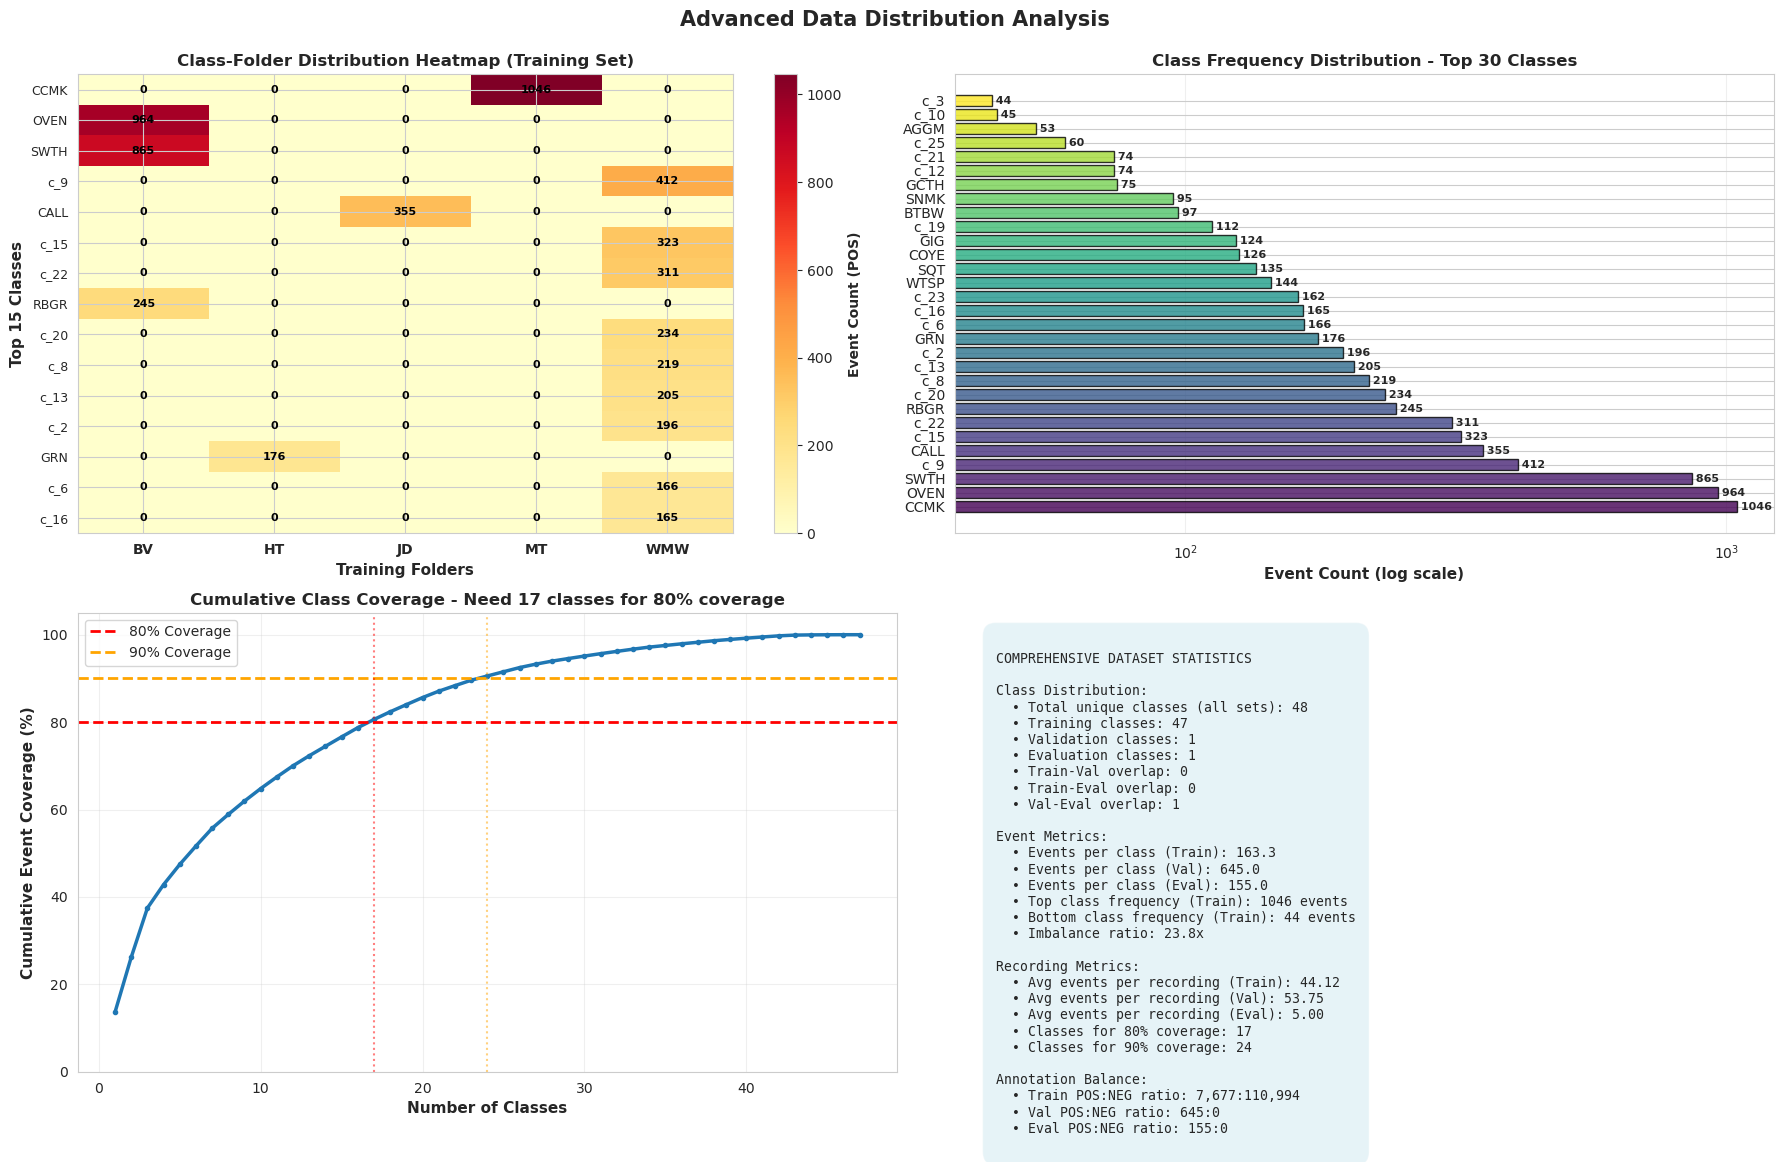

In [14]:
# Create comprehensive class-folder relationship heatmap and analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Class-Folder Heatmap (Training Set)
ax = axes[0, 0]
folder_names = list(train_stats["folders"].keys())
top_classes = sorted(train_stats["all_classes"].items(), 
                     key=lambda x: x[1]["pos"], reverse=True)[:15]
class_names = [c[0] for c in top_classes]

heatmap_data = np.zeros((len(class_names), len(folder_names)))
for i, (class_name, _) in enumerate(top_classes):
    for j, folder_name in enumerate(folder_names):
        heatmap_data[i, j] = train_stats["folders"][folder_name]["classes"].get(class_name, {}).get("pos", 0)

im = ax.imshow(heatmap_data, cmap="YlOrRd", aspect="auto")
ax.set_xticks(range(len(folder_names)))
ax.set_yticks(range(len(class_names)))
ax.set_xticklabels(folder_names, fontsize=10, fontweight="bold")
ax.set_yticklabels([cn[:20] for cn in class_names], fontsize=9)
ax.set_xlabel("Training Folders", fontsize=11, fontweight="bold")
ax.set_ylabel("Top 15 Classes", fontsize=11, fontweight="bold")
ax.set_title("Class-Folder Distribution Heatmap (Training Set)", fontsize=12, fontweight="bold")

# Add text annotations
for i in range(len(class_names)):
    for j in range(len(folder_names)):
        text = ax.text(j, i, int(heatmap_data[i, j]),
                      ha="center", va="center", color="black", fontsize=8, fontweight="bold")

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Event Count (POS)", fontsize=10, fontweight="bold")

# 2. Class frequency distribution with log scale
ax = axes[0, 1]
all_classes_sorted = sorted(train_stats["all_classes"].items(),
                            key=lambda x: x[1]["pos"], reverse=True)[:30]
class_names_freq = [c[0][:20] for c in all_classes_sorted]
class_freqs = [c[1]["pos"] for c in all_classes_sorted]

colors_freq = plt.cm.viridis(np.linspace(0, 1, len(class_names_freq)))
bars = ax.barh(class_names_freq, class_freqs, color=colors_freq, alpha=0.8, edgecolor="black")
ax.set_xscale("log")
ax.set_xlabel("Event Count (log scale)", fontsize=11, fontweight="bold")
ax.set_title("Class Frequency Distribution - Top 30 Classes", fontsize=12, fontweight="bold")
ax.grid(axis="x", alpha=0.3)

for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f" {int(width)}", 
            ha="left", va="center", fontsize=8, fontweight="bold")

# 3. Cumulative class coverage
ax = axes[1, 0]
all_classes_cumulative = sorted(train_stats["all_classes"].items(),
                               key=lambda x: x[1]["pos"], reverse=True)
class_freqs_cumulative = [c[1]["pos"] for c in all_classes_cumulative]
cumsum = np.cumsum(class_freqs_cumulative)
cumsum_pct = 100 * cumsum / cumsum[-1]

ax.plot(range(1, len(cumsum_pct)+1), cumsum_pct, linewidth=2.5, marker="o", markersize=3)
ax.axhline(y=80, color="r", linestyle="--", label="80% Coverage", linewidth=2)
ax.axhline(y=90, color="orange", linestyle="--", label="90% Coverage", linewidth=2)
classes_for_80 = np.argmax(cumsum_pct >= 80) + 1
classes_for_90 = np.argmax(cumsum_pct >= 90) + 1
ax.axvline(x=classes_for_80, color="r", linestyle=":", alpha=0.5)
ax.axvline(x=classes_for_90, color="orange", linestyle=":", alpha=0.5)

ax.set_xlabel("Number of Classes", fontsize=11, fontweight="bold")
ax.set_ylabel("Cumulative Event Coverage (%)", fontsize=11, fontweight="bold")
ax.set_title(f"Cumulative Class Coverage - Need {classes_for_80} classes for 80% coverage", 
             fontsize=12, fontweight="bold")
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.set_ylim([0, 105])

# 4. Dataset statistics comparison table
ax = axes[1, 1]
ax.axis("off")

# Calculate additional statistics
train_events_per_class = train_stats["total_events_pos"] / max(len(train_stats["total_classes"]), 1)
val_events_per_class = val_stats["total_events_pos"] / max(len(val_stats["total_classes"]), 1)
eval_events_per_class = eval_stats["total_events_pos"] / max(len(eval_stats["total_classes"]), 1)

# Calculate class overlap
train_classes_set = set(train_stats["total_classes"])
val_classes_set = set(val_stats["total_classes"])
eval_classes_set = set(eval_stats["total_classes"])
overlap_train_val = len(train_classes_set & val_classes_set)
overlap_train_eval = len(train_classes_set & eval_classes_set)
overlap_val_eval = len(val_classes_set & eval_classes_set)

stats_table = f"""
COMPREHENSIVE DATASET STATISTICS

Class Distribution:
  • Total unique classes (all sets): {len(train_classes_set | val_classes_set | eval_classes_set)}
  • Training classes: {len(train_stats['total_classes'])}
  • Validation classes: {len(val_stats['total_classes'])}
  • Evaluation classes: {len(eval_stats['total_classes'])}
  • Train-Val overlap: {overlap_train_val}
  • Train-Eval overlap: {overlap_train_eval}
  • Val-Eval overlap: {overlap_val_eval}

Event Metrics:
  • Events per class (Train): {train_events_per_class:.1f}
  • Events per class (Val): {val_events_per_class:.1f}
  • Events per class (Eval): {eval_events_per_class:.1f}
  • Top class frequency (Train): {class_freqs[0]} events
  • Bottom class frequency (Train): {class_freqs[-1]} events
  • Imbalance ratio: {class_freqs[0]/max(class_freqs[-1], 1):.1f}x

Recording Metrics:
  • Avg events per recording (Train): {train_stats['total_events_pos']/max(train_stats['total_recordings'], 1):.2f}
  • Avg events per recording (Val): {val_stats['total_events_pos']/max(val_stats['total_recordings'], 1):.2f}
  • Avg events per recording (Eval): {eval_stats['total_events_pos']/max(eval_stats['total_recordings'], 1):.2f}
  • Classes for 80% coverage: {classes_for_80}
  • Classes for 90% coverage: {classes_for_90}

Annotation Balance:
  • Train POS:NEG ratio: {train_stats['total_events_pos']:,}:{train_stats['total_events_neg']:,}
  • Val POS:NEG ratio: {val_stats['total_events_pos']:,}:{val_stats['total_events_neg']:,}
  • Eval POS:NEG ratio: {eval_stats['total_events_pos']:,}:{eval_stats['total_events_neg']:,}
"""

ax.text(0.05, 0.95, stats_table, transform=ax.transAxes,
       fontsize=9.5, verticalalignment="top", fontfamily="monospace",
       bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.3, pad=1))

fig.suptitle("Advanced Data Distribution Analysis", fontsize=15, fontweight="bold", y=0.995)
plt.tight_layout()
plt.show()


In [20]:
# UMAP visualization of class and domain relationships
try:
    import umap
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Prepare data for UMAP: Create a feature matrix based on class statistics
    all_classes_list = list(train_stats["all_classes"].keys())
    n_classes = len(all_classes_list)
    
    # Feature vector: [pos_count, neg_count, domains_present, avg_events_per_domain, imbalance_ratio]
    feature_matrix = []
    class_labels = []
    domain_colors = []
    class_colors = []
    
    domain_color_map = {}
    colors_domain = plt.cm.tab10(np.linspace(0, 1, len(train_stats["folders"])))
    for idx, domain in enumerate(train_stats["folders"].keys()):
        domain_color_map[domain] = colors_domain[idx]
    
    for class_name in all_classes_list:
        class_data = train_stats["all_classes"][class_name]
        
        # Count domains where this class appears
        domains_present = []
        for domain_name in train_stats["folders"].keys():
            if class_name in train_stats["folders"][domain_name]["classes"]:
                domains_present.append(domain_name)
        
        pos = class_data["pos"]
        neg = class_data["neg"]
        total = pos + neg
        
        # Create feature vector
        features = [
            pos,  # POS count
            neg,  # NEG count
            len(domains_present),  # Number of domains
            total / max(len(domains_present), 1),  # Avg events per domain
            pos / max(total, 1),  # POS ratio
        ]
        
        feature_matrix.append(features)
        class_labels.append(class_name)
        
        # Get primary domain for this class
        if domains_present:
            domain_colors.append(domain_color_map[domains_present[0]])
        else:
            domain_colors.append([0.5, 0.5, 0.5, 1.0])
        
        # Color by event count (more saturated = more events)
        class_colors.append(np.log1p(pos))
    
    feature_matrix = np.array(feature_matrix)
    
    # Normalize features for UMAP
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    feature_matrix_scaled = scaler.fit_transform(feature_matrix)
    
    # Apply UMAP with different parameter sets
    # 1. Default UMAP (optimized for structure)
    ax = axes[0, 0]
    reducer_default = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, 
                                metric='euclidean', random_state=42)
    embedding_default = reducer_default.fit_transform(feature_matrix_scaled)
    
    scatter = ax.scatter(embedding_default[:, 0], embedding_default[:, 1], 
                        c=class_colors, s=100, alpha=0.7, edgecolors="black", 
                        cmap="YlOrRd", linewidth=0.5)
    
    ax.set_xlabel(f"UMAP 1", fontsize=11, fontweight="bold")
    ax.set_ylabel(f"UMAP 2", fontsize=11, fontweight="bold")
    ax.set_title("UMAP: Class Relationships (colored by event count)", fontsize=12, fontweight="bold")
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("Log(Event Count)", fontsize=10, fontweight="bold")
    ax.grid(alpha=0.3)
    
    # Annotate top classes
    top_classes_umap = sorted(enumerate(class_colors), key=lambda x: x[1], reverse=True)[:8]
    for idx, _ in top_classes_umap:
        ax.annotate(all_classes_list[idx][:10], 
                   (embedding_default[idx, 0], embedding_default[idx, 1]),
                   fontsize=7, alpha=0.8, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.3))
    
    # 2. UMAP colored by domain
    ax = axes[0, 1]
    scatter = ax.scatter(embedding_default[:, 0], embedding_default[:, 1],
                        c=domain_colors, s=100, alpha=0.7, edgecolors="black", linewidth=0.5)
    
    ax.set_xlabel(f"UMAP 1", fontsize=11, fontweight="bold")
    ax.set_ylabel(f"UMAP 2", fontsize=11, fontweight="bold")
    ax.set_title("UMAP: Domain Separation", fontsize=12, fontweight="bold")
    
    # Create custom legend for domains
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=domain_color_map[d], label=d, edgecolor="black") 
                      for d in train_stats["folders"].keys()]
    ax.legend(handles=legend_elements, loc="best", fontsize=9)
    ax.grid(alpha=0.3)
    
    # 3. UMAP with tight layout (better for clusters)
    ax = axes[1, 0]
    reducer_tight = umap.UMAP(n_components=2, n_neighbors=5, min_dist=0.5, 
                              metric='euclidean', random_state=42)
    embedding_tight = reducer_tight.fit_transform(feature_matrix_scaled)
    
    scatter = ax.scatter(embedding_tight[:, 0], embedding_tight[:, 1],
                        c=class_colors, s=100, alpha=0.7, edgecolors="black",
                        cmap="viridis", linewidth=0.5)
    
    ax.set_xlabel(f"UMAP 1 (Tight)", fontsize=11, fontweight="bold")
    ax.set_ylabel(f"UMAP 2 (Tight)", fontsize=11, fontweight="bold")
    ax.set_title("UMAP: Tight Clustering (n_neighbors=5, min_dist=0.5)", fontsize=12, fontweight="bold")
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("Log(Event Count)", fontsize=10, fontweight="bold")
    ax.grid(alpha=0.3)
    
    # 4. Feature importance & statistics
    ax = axes[1, 1]
    ax.axis("off")
    
    umap_stats = f"""
UMAP DIMENSIONALITY REDUCTION ANALYSIS

Dataset Characteristics:
  • Total classes analyzed: {len(all_classes_list)}
  • Total domains: {len(train_stats['folders'])}
  • Feature dimensions: {feature_matrix.shape[1]}
    - POS event count
    - NEG event count
    - Domain presence count
    - Events per domain (avg)
    - POS ratio (balance)

Class Feature Statistics:
  • Mean POS count: {np.mean(feature_matrix[:, 0]):.1f}
  • Mean NEG count: {np.mean(feature_matrix[:, 1]):.1f}
  • Mean domains per class: {np.mean(feature_matrix[:, 2]):.2f}
  • Mean events per domain: {np.mean(feature_matrix[:, 3]):.1f}
  • Mean POS ratio: {np.mean(feature_matrix[:, 4]):.3f}

UMAP Interpretations:
  • Distance between classes indicates similarity
  • Clusters suggest natural groupings
  • Domain coloring shows cross-domain patterns
  • Proximity = similar event characteristics

Model Parameters (Default):
  • n_neighbors: 15 (local structure)
  • min_distance: 0.1 (compact representation)
  • metric: euclidean
  
Model Parameters (Tight):
  • n_neighbors: 5 (very local)
  • min_distance: 0.5 (preserve separation)
  • metric: euclidean

Observations:
  • Colored by event count: Shows class frequency
  • Domain coloring: Reveals domain specialization
  • Multiple clusters: Indicates distinct class groups
"""

    ax.text(0.05, 0.95, umap_stats, transform=ax.transAxes,
           fontsize=9, verticalalignment="top", fontfamily="monospace",
           bbox=dict(boxstyle="round", facecolor="lightcyan", alpha=0.3, pad=1))
    
    fig.suptitle("UMAP: High-Dimensional Class and Domain Space", fontsize=15, fontweight="bold", y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("✓ UMAP visualization complete!")
    print(f"  - Classes visualized: {len(all_classes_list)}")
    print(f"  - Preserved local structure: n_neighbors=15, min_distance=0.1")
    print(f"  - Tight clustering mode: n_neighbors=5, min_distance=0.5")
    
except ImportError:
    print("UMAP not available. Install with: pip install umap-learn scikit-learn")
except Exception as e:
    print(f"UMAP visualization error: {e}")
    import traceback
    traceback.print_exc()


UMAP not available. Install with: pip install umap-learn scikit-learn


## Section 15: UMAP Dimensionality Reduction & Cluster Visualization
High-dimensional visualization of class relationships and natural clusters in feature space.

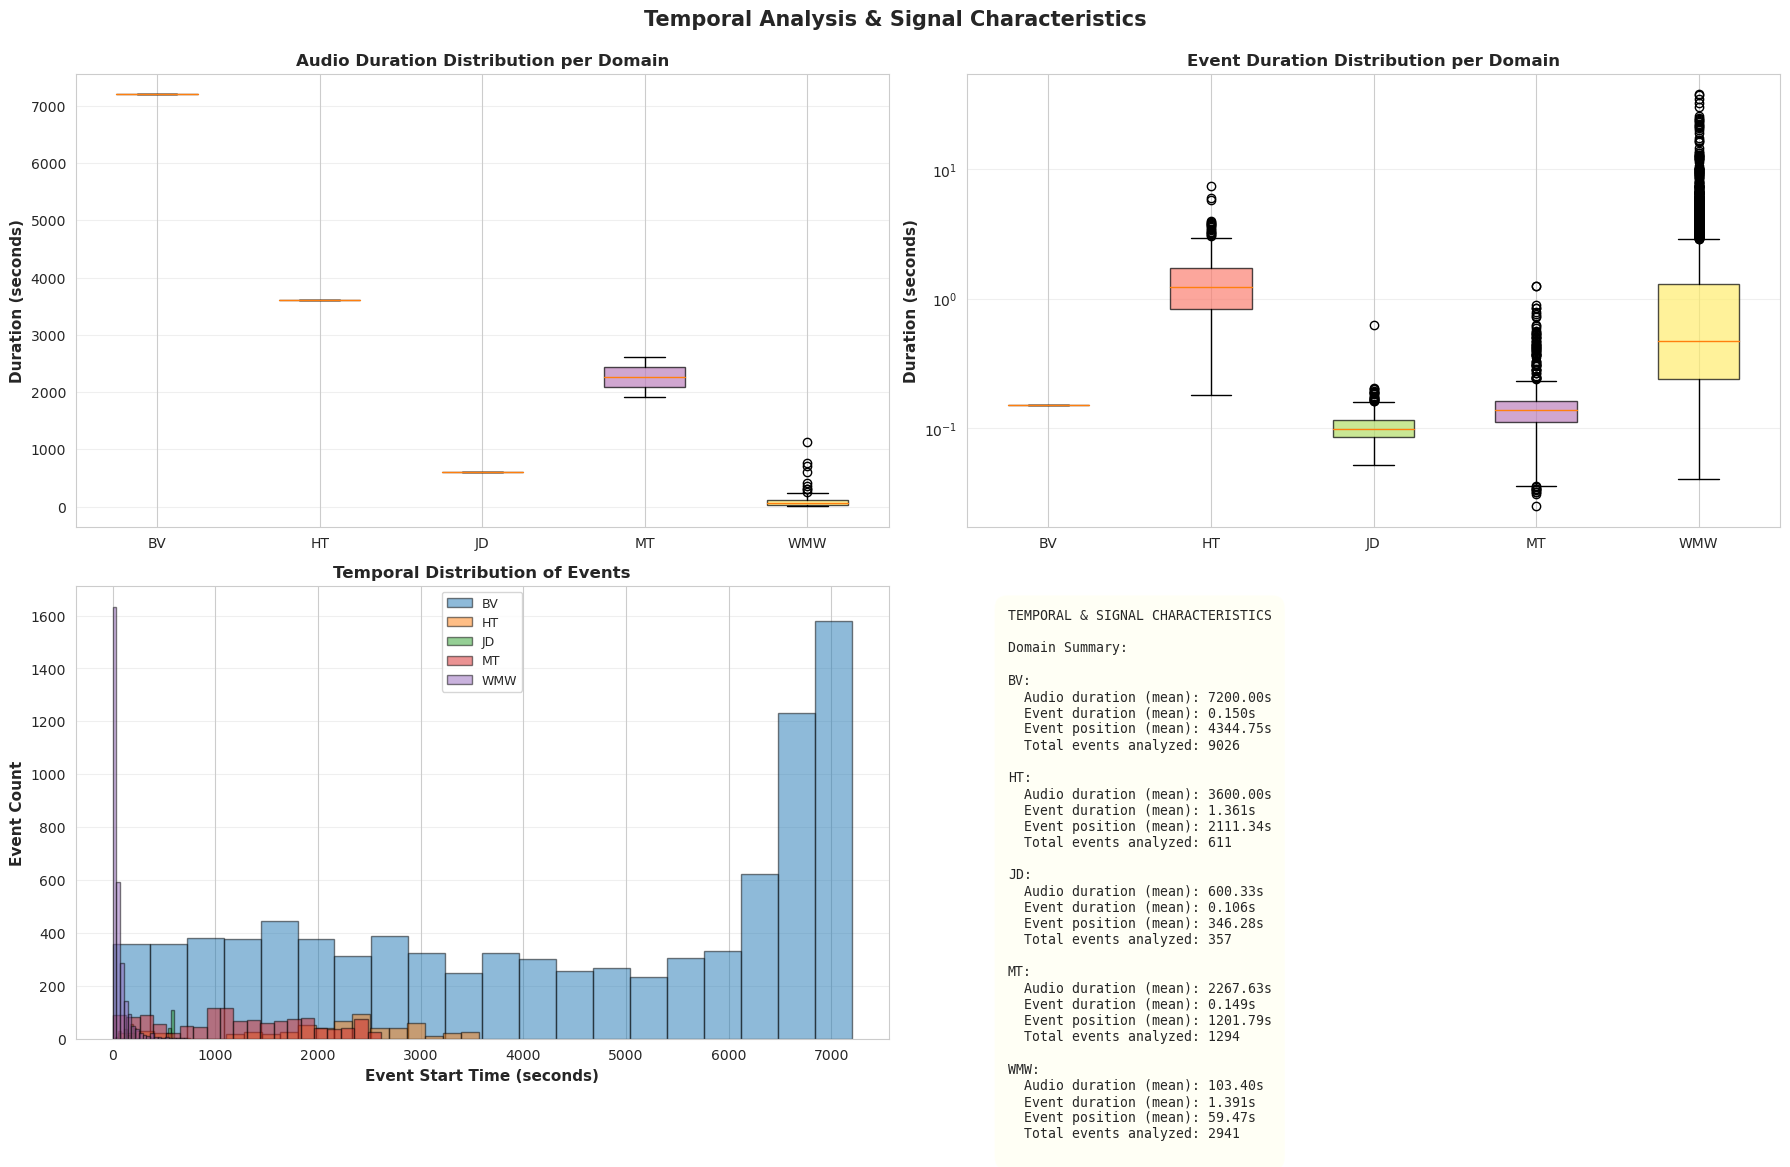

✓ Temporal analysis complete!


In [16]:
# Temporal analysis and signal characteristics
try:
    import librosa
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Extract temporal statistics from annotations
    temporal_stats = {}
    for domain_name in train_stats["folders"].keys():
        domain_path = train_dir / domain_name
        audio_files = list(domain_path.glob("*.wav"))
        
        durations = []
        event_times = []
        event_durations = []
        
        for audio_file in audio_files:
            csv_file = audio_file.with_suffix(".csv")
            
            try:
                # Get audio duration
                y, sr = librosa.load(str(audio_file), sr=None)
                duration = len(y) / sr
                durations.append(duration)
                
                # Get event times from CSV
                if csv_file.exists():
                    df = pd.read_csv(csv_file)
                    for idx, row in df.iterrows():
                        try:
                            start_time = float(row['Starttime'])
                            end_time = float(row['Endtime'])
                            event_duration = end_time - start_time
                            event_durations.append(event_duration)
                            event_times.append(start_time)
                        except (ValueError, KeyError):
                            pass
            except Exception as e:
                pass
        
        if durations and event_durations:
            temporal_stats[domain_name] = {
                "audio_durations": durations,
                "event_times": event_times,
                "event_durations": event_durations,
                "mean_audio_duration": np.mean(durations),
                "mean_event_duration": np.mean(event_durations),
                "mean_event_position": np.mean(event_times) if event_times else 0,
            }
    
    # 1. Audio duration distribution by domain
    ax = axes[0, 0]
    domain_names_temp = list(temporal_stats.keys())
    domain_audio_durs = [temporal_stats[d]["audio_durations"] for d in domain_names_temp]
    
    bp = ax.boxplot(domain_audio_durs, labels=domain_names_temp, patch_artist=True)
    for patch, color in zip(bp['boxes'], plt.cm.Set3(np.linspace(0, 1, len(domain_names_temp)))):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_ylabel("Duration (seconds)", fontsize=11, fontweight="bold")
    ax.set_title("Audio Duration Distribution per Domain", fontsize=12, fontweight="bold")
    ax.grid(axis="y", alpha=0.3)
    
    # 2. Event duration distribution by domain
    ax = axes[0, 1]
    domain_event_durs = [temporal_stats[d]["event_durations"] for d in domain_names_temp]
    
    bp = ax.boxplot(domain_event_durs, labels=domain_names_temp, patch_artist=True)
    for patch, color in zip(bp['boxes'], plt.cm.Set3(np.linspace(0, 1, len(domain_names_temp)))):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_ylabel("Duration (seconds)", fontsize=11, fontweight="bold")
    ax.set_title("Event Duration Distribution per Domain", fontsize=12, fontweight="bold")
    ax.set_yscale("log")
    ax.grid(axis="y", alpha=0.3)
    
    # 3. Event temporal distribution (when events occur in audio)
    ax = axes[1, 0]
    all_event_times = []
    all_event_domain = []
    
    for domain_name in domain_names_temp:
        all_event_times.extend(temporal_stats[domain_name]["event_times"])
        all_event_domain.extend([domain_name] * len(temporal_stats[domain_name]["event_times"]))
    
    domain_time_data = {}
    for domain_name in domain_names_temp:
        domain_time_data[domain_name] = [t for t, d in zip(all_event_times, all_event_domain) if d == domain_name]
    
    for i, domain_name in enumerate(domain_names_temp):
        times = domain_time_data[domain_name]
        if times:
            ax.hist(times, bins=20, alpha=0.5, label=domain_name, edgecolor="black")
    
    ax.set_xlabel("Event Start Time (seconds)", fontsize=11, fontweight="bold")
    ax.set_ylabel("Event Count", fontsize=11, fontweight="bold")
    ax.set_title("Temporal Distribution of Events", fontsize=12, fontweight="bold")
    ax.legend(fontsize=9)
    ax.grid(axis="y", alpha=0.3)
    
    # 4. Summary statistics table
    ax = axes[1, 1]
    ax.axis("off")
    
    summary_temporal = "TEMPORAL & SIGNAL CHARACTERISTICS\n\nDomain Summary:\n"
    for domain_name in domain_names_temp:
        stats = temporal_stats[domain_name]
        summary_temporal += f"\n{domain_name}:\n"
        summary_temporal += f"  Audio duration (mean): {stats['mean_audio_duration']:.2f}s\n"
        summary_temporal += f"  Event duration (mean): {stats['mean_event_duration']:.3f}s\n"
        summary_temporal += f"  Event position (mean): {stats['mean_event_position']:.2f}s\n"
        summary_temporal += f"  Total events analyzed: {len(stats['event_times'])}\n"
    
    ax.text(0.05, 0.95, summary_temporal, transform=ax.transAxes,
           fontsize=9.5, verticalalignment="top", fontfamily="monospace",
           bbox=dict(boxstyle="round", facecolor="lightyellow", alpha=0.3, pad=1))
    
    fig.suptitle("Temporal Analysis & Signal Characteristics", fontsize=15, fontweight="bold", y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("✓ Temporal analysis complete!")
    
except ImportError:
    print("librosa not available for detailed temporal analysis")
    print("Install with: pip install librosa")
except Exception as e:
    print(f"Temporal analysis error: {e}")


## Section 14: Temporal Analysis & Signal Characteristics
Analyzing temporal patterns, event duration statistics, and signal properties across domains.

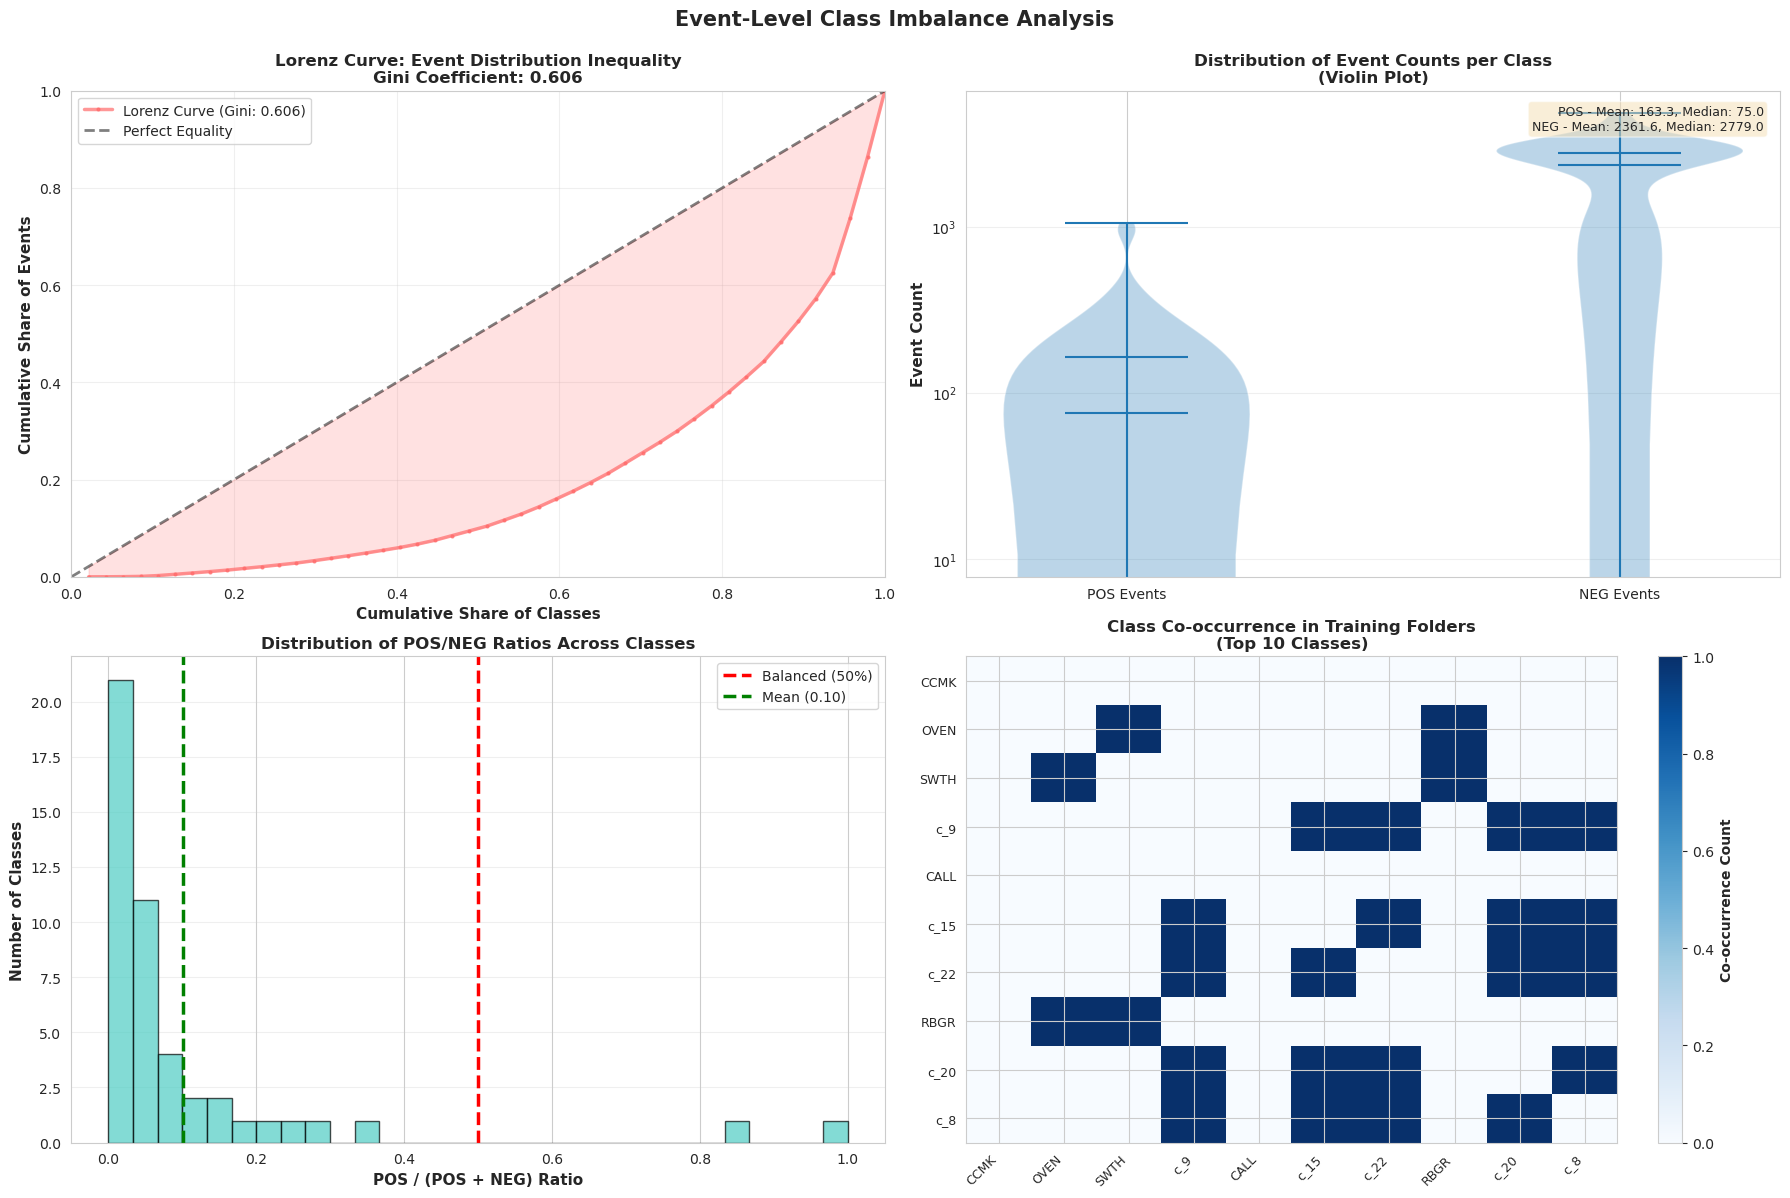

✓ Event-level analysis complete!
  - Gini coefficient: 0.6061 (0=perfect equality, 1=perfect inequality)
  - Mean POS/NEG ratio: 0.101


In [17]:
# Event-level class imbalance analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Gini Coefficient for class distribution inequality
ax = axes[0, 0]
all_classes_gini = sorted(train_stats["all_classes"].items(),
                          key=lambda x: x[1]["pos"], reverse=True)
class_events_list = [c[1]["pos"] for c in all_classes_gini]

# Calculate Gini coefficient
sorted_events = np.sort(class_events_list)
n = len(sorted_events)
cumsum = np.cumsum(sorted_events)
gini = (2 * np.sum(np.arange(1, n+1) * sorted_events)) / (n * np.sum(sorted_events)) - (n + 1) / n

# Plot Lorenz curve
cumulative_events = np.cumsum(sorted_events) / np.sum(sorted_events)
cumulative_classes = np.arange(1, n+1) / n

ax.plot(cumulative_classes, cumulative_events, linewidth=2.5, label=f"Lorenz Curve (Gini: {gini:.3f})",
       color="#FF6B6B", marker="o", markersize=2, alpha=0.7)
ax.plot([0, 1], [0, 1], "k--", linewidth=2, label="Perfect Equality", alpha=0.5)
ax.fill_between(cumulative_classes, cumulative_events, cumulative_classes, alpha=0.2, color="#FF6B6B")

ax.set_xlabel("Cumulative Share of Classes", fontsize=11, fontweight="bold")
ax.set_ylabel("Cumulative Share of Events", fontsize=11, fontweight="bold")
ax.set_title(f"Lorenz Curve: Event Distribution Inequality\nGini Coefficient: {gini:.3f}", 
            fontsize=12, fontweight="bold")
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# 2. Distribution of class sizes (violin plot)
ax = axes[0, 1]
class_sizes_list = [c["pos"] for c in train_stats["all_classes"].values()]
class_sizes_pos = [c["pos"] for c in train_stats["all_classes"].values()]
class_sizes_neg = [c["neg"] for c in train_stats["all_classes"].values()]

data_to_plot = [class_sizes_pos, class_sizes_neg]
parts = ax.violinplot(data_to_plot, positions=[1, 2], showmeans=True, showmedians=True)

ax.set_ylabel("Event Count", fontsize=11, fontweight="bold")
ax.set_title("Distribution of Event Counts per Class\n(Violin Plot)", fontsize=12, fontweight="bold")
ax.set_xticks([1, 2])
ax.set_xticklabels(["POS Events", "NEG Events"])
ax.set_yscale("log")
ax.grid(axis="y", alpha=0.3)

# Add statistics
pos_median = np.median(class_sizes_pos)
pos_mean = np.mean(class_sizes_pos)
neg_median = np.median(class_sizes_neg)
neg_mean = np.mean(class_sizes_neg)

stats_text = f"POS - Mean: {pos_mean:.1f}, Median: {pos_median:.1f}\nNEG - Mean: {neg_mean:.1f}, Median: {neg_median:.1f}"
ax.text(0.98, 0.97, stats_text, transform=ax.transAxes,
       fontsize=9, verticalalignment="top", horizontalalignment="right",
       bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

# 3. Event imbalance ratio distribution
ax = axes[1, 0]
imbalance_ratios_all = []
for class_name, class_data in train_stats["all_classes"].items():
    pos = class_data["pos"]
    neg = class_data["neg"]
    total = pos + neg
    if total > 0:
        ratio = pos / total
        imbalance_ratios_all.append(ratio)

ax.hist(imbalance_ratios_all, bins=30, alpha=0.7, edgecolor="black", color="#4ECDC4")
ax.axvline(x=0.5, color="r", linestyle="--", linewidth=2.5, label="Balanced (50%)")
ax.axvline(x=np.mean(imbalance_ratios_all), color="g", linestyle="--", linewidth=2.5, 
          label=f"Mean ({np.mean(imbalance_ratios_all):.2f})")

ax.set_xlabel("POS / (POS + NEG) Ratio", fontsize=11, fontweight="bold")
ax.set_ylabel("Number of Classes", fontsize=11, fontweight="bold")
ax.set_title("Distribution of POS/NEG Ratios Across Classes", fontsize=12, fontweight="bold")
ax.legend(fontsize=10)
ax.grid(axis="y", alpha=0.3)

# 4. Class co-occurrence matrix
ax = axes[1, 1]
top_classes_cooc = sorted(train_stats["all_classes"].items(),
                          key=lambda x: x[1]["pos"], reverse=True)[:10]
class_names_cooc = [c[0][:15] for c in top_classes_cooc]

# For a simplified co-occurrence, check if classes appear together in training folders
cooc_matrix = np.zeros((len(class_names_cooc), len(class_names_cooc)))
for i, (class1_name, _) in enumerate(top_classes_cooc):
    for j, (class2_name, _) in enumerate(top_classes_cooc):
        if i != j:
            for folder_data in train_stats["folders"].values():
                if (class1_name in folder_data["classes"] and class2_name in folder_data["classes"]):
                    cooc_matrix[i, j] += 1

im = ax.imshow(cooc_matrix, cmap="Blues", aspect="auto")
ax.set_xticks(range(len(class_names_cooc)))
ax.set_yticks(range(len(class_names_cooc)))
ax.set_xticklabels(class_names_cooc, rotation=45, ha="right", fontsize=9)
ax.set_yticklabels(class_names_cooc, fontsize=9)
ax.set_title("Class Co-occurrence in Training Folders\n(Top 10 Classes)", fontsize=12, fontweight="bold")

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Co-occurrence Count", fontsize=10, fontweight="bold")

fig.suptitle("Event-Level Class Imbalance Analysis", fontsize=15, fontweight="bold", y=0.995)
plt.tight_layout()
plt.show()

print(f"✓ Event-level analysis complete!")
print(f"  - Gini coefficient: {gini:.4f} (0=perfect equality, 1=perfect inequality)")
print(f"  - Mean POS/NEG ratio: {np.mean(imbalance_ratios_all):.3f}")


## Section 13: Event-Level Class Imbalance Analysis
Deep analysis of event-level distributions and class co-occurrence patterns.

## Section 10: Advanced Data Distribution Analysis
Comprehensive visualizations for deeper data understanding.